<a href="https://colab.research.google.com/github/Angatang/University-Recommender/blob/main/Uni_Recommender_(FULL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
df = pd.read_excel("/content/Data_21-24 (1)-1.xlsx", index_col=0)

In [ ]:
df.head()

,Email,Gender,Interested Countries,Parent Phone Number,Student Phone Number,Passport Number,Requires Essay,Requires Lor,Requires Sop,Term Name,...,College Details,First Year Score,Second Year Score,Third Year Score,Fourth Year Score,Fifth Year Score,Sixth Year Score,Seventh Year Score,Eighth Year Score,Profile Statuses
Full Name,,,,,,,,,,,,,,,,,,,,,
Aniket Dandawate,aniket.dandawate.nice@gmail.com,0,France,912342342342,732981273922,231231212,True,True,True,Fall - 2024,...,"Computer Science, College: Walchand College of...",0.00,3.00,3.00,3.00,NaN,NaN,NaN,NaN,ProfileApproved|LorSent
Abhiroop Ramachandran,abhiroop.mattiyil@gmail.com,2,United States,919833965688,918652344555,R5589324,False,True,True,Fall - 2024,...,"EXTC, College: DJ SANGHVI COLLEGE OF ENGINEERI...",8.00,7.22,7.57,100.00,0.0,NaN,NaN,NaN,ProfileApproved|LorSent|SopSent|Finalized
MANALI BHOSLE,manalibhosale239@gmail.com,1,United States,919892179547,919930041940,T2898245,False,True,True,Fall - 2024,...,"COMPUTER ENGINEERING, College: Lokmanya Tilak ...",6.14,7.47,8.02,10.00,0.0,NaN,NaN,NaN,ProfileApproved|LorSent|SopSent|Finalized
Shivani Zemse,spzemse01@gmail.com,1,United States,919821439101,919870040602,R0804371,False,True,True,Fall - 2024,...,"BE IT, College: Shah & Anchor Kutchhi Engineer...",7.11,6.46,7.94,9.21,0.0,NaN,NaN,NaN,ProfileApproved|LorSent|SopSent|Finalized
Gaurav Purohit,purohitgauravs0896@gmail.com,2,United States,919322407965,918652168657,K1415996,False,True,True,Fall - 2024,...,"Bachelor of Biotechnology, College: B. N. Band...",4.75,6.15,5.50,NaN,NaN,NaN,NaN,NaN,ProfileApproved|LorSent|SopSent|AwaitingAdmit


In [ ]:
if 'Is Competitive Exam Given' in df.columns:
    print("Column 'Is Competitive Exam Given' exists in df.")
    print("Value Counts (including NaNs):")
    print(df['Is Competitive Exam Given'].value_counts(dropna=False))
    # Check data type as well
    print(f"Data type: {df['Is Competitive Exam Given'].dtype}")

    # Also, let's re-check the scores *before* they are potentially overwritten
    # Make sure the column name is correct for your raw data before conversion
    print("\nChecking original competitive scores in df_us (after potential to_numeric):")
    original_scores = pd.to_numeric(df['Total Score (Competitive Exam)'], errors='coerce')
    print(original_scores.value_counts(dropna=False))

else:
    print("ERROR: Column 'Is Competitive Exam Given' DOES NOT EXIST in df!")

Column 'Is Competitive Exam Given' exists in df.
Value Counts (including NaNs):
Is Competitive Exam Given
1.0    2331
0.0    1401
NaN     104
Name: count, dtype: int64
Data type: float64

Checking original competitive scores in df_us (after potential to_numeric):
Total Score (Competitive Exam)
NaN       1505
305.0       74
304.0       73
312.0       70
314.0       69
          ... 
740.0        1
480.0        1
1290.0       1
1050.0       1
840.0        1
Name: count, Length: 127, dtype: int64


In [ ]:
print("\nParsing College Details...")

def parse_college_details(details):
    if pd.isna(details):
        return pd.Series([np.nan] * 4) # Return NaNs if input is NaN

    # Regex to capture: Major, College, University, Year
    # Adjust pattern if format varies significantly
    # Using non-greedy matching (.*?) and being specific about keywords
    pattern = r"^(.*?),\s*College:\s*(.*?),\s*University:\s*(.*?),\s*Year:\s*(\d{4})$"
    match = re.search(pattern, str(details).strip())

    if match:
        ug_major = match.group(1).strip()
        ug_college = match.group(2).strip()
        ug_university = match.group(3).strip()
        ug_year = int(match.group(4)) # Convert year to integer
        return pd.Series([ug_major, ug_college, ug_university, ug_year])
    else:
        # Attempt simpler parsing if primary fails (e.g. if missing parts)
        # Fallback: return NaNs or try extracting at least year/major if possible
        # This part might need refinement based on actual variations in your data
        year_match = re.search(r"Year:\s*(\d{4})", str(details))
        ug_year = int(year_match.group(1)) if year_match else np.nan
        # Add more fallback logic if needed
        return pd.Series([np.nan] * 3 + [ug_year]) # Example fallback

# Apply the function to create new columns
parsed_cols = ['UG_Major', 'UG_College_Name', 'UG_University_Name', 'UG_Year_of_Graduation']
df[parsed_cols] = df['College Details'].apply(parse_college_details)



Parsing College Details...


In [ ]:
print("\nCalculating Overall GPA on 4.0 Scale...")

# Define the list of score columns
score_columns = [
    'First Year Score', 'Second Year Score', 'Third Year Score',
    'Fourth Year Score', 'Fifth Year Score', 'Sixth Year Score',
    'Seventh Year Score', 'Eighth Year Score'
]

# Convert score columns to numeric, coercing errors to NaN
for col in score_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

def calculate_gpa_4_scale(row):
    system = row['Grading Systen']
    scores = row[score_columns].tolist()
    valid_scores = []

    if pd.isna(system):
        return np.nan

    # Determine scale and outlier bounds
    max_scale = np.nan
    lower_bound = np.nan
    upper_bound = np.nan

    if system == 'CGPA10':
        max_scale = 10.0
        lower_bound = 1.0 # Adjust if lower scores are valid
        upper_bound = 10.0
    elif system == 'GPA7':
        max_scale = 7.0
        lower_bound = 1.0 # Adjust if lower scores are valid
        upper_bound = 7.0
    elif system == 'Default': # Percentage scale
        max_scale = 100.0
        lower_bound = 35.0 # Assuming scores below 35% are outliers/fails to ignore
        upper_bound = 100.0
    else: # Handle unexpected systems
        return np.nan

    # Filter scores
    for score in scores:
        if pd.notna(score) and lower_bound <= score <= upper_bound:
             valid_scores.append(score)

    # Calculate average and convert
    if not valid_scores: # Check if list is empty
        return np.nan
    else:
        average_score = sum(valid_scores) / len(valid_scores)
        return (average_score / max_scale) * 4.0

# Apply the function row-wise
df['Overall_GPA_4_Scale'] = df.apply(calculate_gpa_4_scale, axis=1)



Calculating Overall GPA on 4.0 Scale...


In [ ]:
if 'Is Competitive Exam Given' in df.columns:
    print("Column 'Is Competitive Exam Given' exists in df.")
    print("Value Counts (including NaNs):")
    print(df['Is Competitive Exam Given'].value_counts(dropna=False))
    # Check data type as well
    print(f"Data type: {df['Is Competitive Exam Given'].dtype}")

    # Also, let's re-check the scores *before* they are potentially overwritten
    # Make sure the column name is correct for your raw data before conversion
    print("\nChecking original competitive scores in df_us (after potential to_numeric):")
    original_scores = pd.to_numeric(df['Total Score (Competitive Exam)'], errors='coerce')
    print(original_scores.value_counts(dropna=False))

else:
    print("ERROR: Column 'Is Competitive Exam Given' DOES NOT EXIST in df!")

Column 'Is Competitive Exam Given' exists in df.
Value Counts (including NaNs):
Is Competitive Exam Given
1.0    2331
0.0    1401
NaN     104
Name: count, dtype: int64
Data type: float64

Checking original competitive scores in df_us (after potential to_numeric):
Total Score (Competitive Exam)
NaN       1505
305.0       74
304.0       73
312.0       70
314.0       69
          ... 
740.0        1
480.0        1
1290.0       1
1050.0       1
840.0        1
Name: count, Length: 127, dtype: int64


In [ ]:
print("\nHandling Test Scores")

# Define Max Scores
MAX_SCORES = {
    'GRE': 340,
    'GMAT': 800,  # Traditional GMAT Max
    'SAT': 1600,
    'ACT': 36
}

# --- Language Exam (No changes needed here from previous correction) ---
lang_score_col = 'Total Score (Language Exam)'
lang_given_col = 'Is Language Exam Given'
df[lang_score_col] = pd.to_numeric(df[lang_score_col], errors='coerce')
df[lang_given_col] = pd.to_numeric(df[lang_given_col], errors='coerce')
df.loc[(df[lang_given_col] == 0.0) | (df[lang_given_col].isna()), lang_score_col] = 0
df.loc[(df[lang_given_col] == 1.0) & (df[lang_score_col].isna()), lang_score_col] = -2

# --- Competitive Exam ---
comp_score_col = 'Total Score (Competitive Exam)'
comp_given_col = 'Is Competitive Exam Given'
comp_exam_type_col = 'Competitive Exam' # Column specifying GRE/GMAT/SAT/ACT

# Ensure score column is numeric
df[comp_score_col] = pd.to_numeric(df[comp_score_col], errors='coerce')
# Ensure 'Is Given' column is numeric/float
df[comp_given_col] = pd.to_numeric(df[comp_given_col], errors='coerce')

# Apply logic based on the 'Is Given' flag (1.0 = Yes, 0.0 = No, NaN = Treat as No)
df.loc[(df[comp_given_col] == 0.0) | (df[comp_given_col].isna()), comp_score_col] = 0
df.loc[(df[comp_given_col] == 1.0) & (df[comp_score_col].isna()), comp_score_col] = -2

# !!! NEW CAPPING LOGIC !!!
# Ensure the Exam Type column is string and handle potential NaNs
df[comp_exam_type_col] = df[comp_exam_type_col].astype(str).fillna('UNKNOWN')

print("Applying score capping...")
for exam_type, max_score in MAX_SCORES.items():
    # Condition for rows matching the exam type AND score exceeding max
    condition = (
        (df[comp_exam_type_col].str.upper() == exam_type) &
        (df[comp_score_col] > max_score)
    )
    # Apply capping
    count_capped = condition.sum()
    if count_capped > 0:
        print(f"Capping {count_capped} scores for {exam_type} at {max_score}")
        df.loc[condition, comp_score_col] = max_score

# --- Verification ---
print("Sample processed test scores (Corrected + Capped):")
print(df[[lang_given_col, lang_score_col, comp_given_col, comp_score_col, comp_exam_type_col]].head())
print("\nValue counts for Competitive Score after correction + capping:")
# Check if capping worked by looking at max values per exam type if needed
# print(df_us.groupby(comp_exam_type_col)[comp_score_col].max())
print(df[comp_score_col].value_counts(dropna=False))


Handling Test Scores
Applying score capping...
Sample processed test scores (Corrected + Capped):
                       Is Language Exam Given  Total Score (Language Exam)  \
Full Name                                                                    
Aniket Dandawate                          0.0                          0.0   
Abhiroop Ramachandran                     1.0                        107.0   
MANALI BHOSLE                             1.0                          6.0   
Shivani Zemse                             1.0                        107.0   
Gaurav Purohit                            1.0                        107.0   

                       Is Competitive Exam Given  \
Full Name                                          
Aniket Dandawate                             0.0   
Abhiroop Ramachandran                        1.0   
MANALI BHOSLE                                0.0   
Shivani Zemse                                1.0   
Gaurav Purohit                            

In [ ]:
print("\nParsing AdmitReceived Universities...")

def extract_admits_finalized(text): # Renamed function slightly for clarity
    """
    Parses 'Suggested Universities' text, extracting names for universities
    marked as either 'AdmitReceived' or 'Finalized'.
    """
    admitted_unis = []
    if isinstance(text, str):
        lines = text.split('\n')
        for line in lines:
            # --- MODIFIED CONDITION ---
            # Check if either status indicator is present in the line
            if "| AdmitReceived |" in line or "| Finalized |" in line:
            # --------------------------
                try:
                    # Extract text before the first pipe, strip whitespace
                    uni_name = line.split('|')[0].strip()
                    if uni_name: # Ensure it's not empty
                        admitted_unis.append(uni_name)
                except IndexError:
                    # Handle lines that might not have a pipe correctly
                    print(f"Warning: Could not parse university name from line: {line}")
                    continue
    return admitted_unis # Return list (can be empty)

df['AdmitReceived_Universities'] = df['Suggested Universities'].apply(extract_admits)



Parsing AdmitReceived Universities...


In [ ]:
print("\nSelecting final columns for EDA...")

columns_for_eda = [
    # Parsed UG Details
    'UG_Major',
    'UG_College_Name',
    'UG_University_Name',
    'UG_Year_of_Graduation',

    # Calculated GPA
    'Overall_GPA_4_Scale',

    # Test Information
    'Language Exam', # Type (TOEFL/IELTS)
    'Total Score (Language Exam)', # Processed score
    'Competitive Exam', # Type (GRE/GMAT)
    'Total Score (Competitive Exam)', # Processed score

    # Desired Course Info
    'Desired Field of Study',
    'Desired Specialization',
    # *** ADDED THIS LINE ***
    'Future Desired Degree', # e.g., Masters, Bachelors

    # Target Variable
    'AdmitReceived_Universities'
]

# Ensure all selected columns exist in df before selection
# This part remains the same
existing_columns_for_eda = [col for col in columns_for_eda if col in df.columns]
missing_original_cols = [col for col in columns_for_eda if col not in df.columns]
if missing_original_cols:
    print(f"Warning: The following columns specified in columns_for_eda were not found in df: {missing_original_cols}")

df_cleaned = df[existing_columns_for_eda].copy()

print("\nCleaned DataFrame Info (After correcting column selection):")
df_cleaned.info()
df_cleaned.info()
print("\nSample of Cleaned DataFrame:")
print(df_cleaned.head())
print("\nChecking for NaNs in key numeric columns:")
print(df_cleaned[['Overall_GPA_4_Scale', 'Total Score (Language Exam)', 'Total Score (Competitive Exam)']].isnull().sum())



Selecting final columns for EDA...

Cleaned DataFrame Info (After correcting column selection):
<class 'pandas.core.frame.DataFrame'>
Index: 3836 entries, Aniket Dandawate to JayaShankar Mangina
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   UG_Major                        3772 non-null   object 
 1   UG_College_Name                 3772 non-null   object 
 2   UG_University_Name              3772 non-null   object 
 3   UG_Year_of_Graduation           3772 non-null   float64
 4   Overall_GPA_4_Scale             2937 non-null   float64
 5   Language Exam                   3732 non-null   object 
 6   Total Score (Language Exam)     3836 non-null   float64
 7   Competitive Exam                3836 non-null   object 
 8   Total Score (Competitive Exam)  3836 non-null   float64
 9   Desired Field of Study          3772 non-null   object 
 10  Desired Specialization          23

In [ ]:
df_cleaned.describe()

,UG_Year_of_Graduation,Overall_GPA_4_Scale,Total Score (Language Exam),Total Score (Competitive Exam)
count,3772.000000,2937.000000,3836.000000,3836.000000
mean,2020.257158,3.403052,41.200730,200.517075
std,2.534857,0.546056,46.425131,196.041291
min,1999.000000,0.400000,0.000000,0.000000
25%,2019.000000,2.972000,6.000000,0.000000
50%,2021.000000,3.426667,7.000000,294.000000
75%,2022.000000,4.000000,95.000000,310.000000
max,2028.000000,4.000000,120.000000,1570.000000


#EDA

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


--- EDA Phase 1: Univariate Analysis ---
Duplicate index labels found. Resetting index...
Index reset complete.


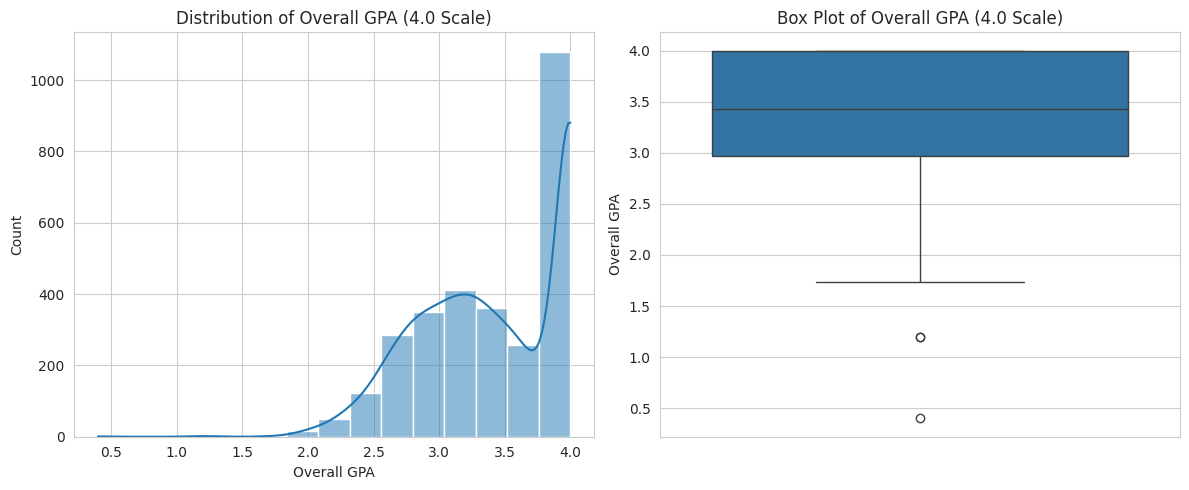

In [ ]:
# --- EDA Phase 1: Univariate Analysis ---
print("\n--- EDA Phase 1: Univariate Analysis ---")

if df_cleaned.index.duplicated().any():
    print("Duplicate index labels found. Resetting index...")
    df_cleaned.reset_index(drop=True, inplace=True)
    print("Index reset complete.")
else:
    print("Index seems unique. No reset needed.")


# 1. Overall GPA Distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) # 1 row, 2 cols, plot 1
sns.histplot(df_cleaned['Overall_GPA_4_Scale'].dropna(), kde=True, bins=15)
plt.title('Distribution of Overall GPA (4.0 Scale)')
plt.xlabel('Overall GPA')

plt.subplot(1, 2, 2) # 1 row, 2 cols, plot 2
sns.boxplot(y=df_cleaned['Overall_GPA_4_Scale'])
plt.title('Box Plot of Overall GPA (4.0 Scale)')
plt.ylabel('Overall GPA')
plt.tight_layout()
plt.show()


--- EDA Phase 1: Step 2 - Competitive Exam Score Distribution (Split by Type) ---
Found competitive exam types for plotting: ['GRE', 'SAT', 'ACT', 'GMAT']

Analyzing GRE Scores...


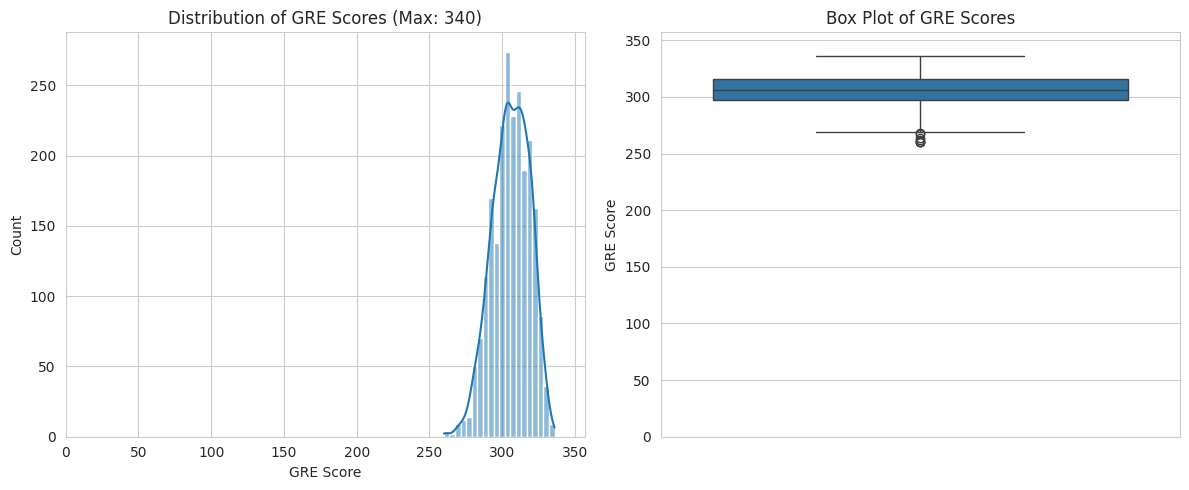


Analyzing SAT Scores...


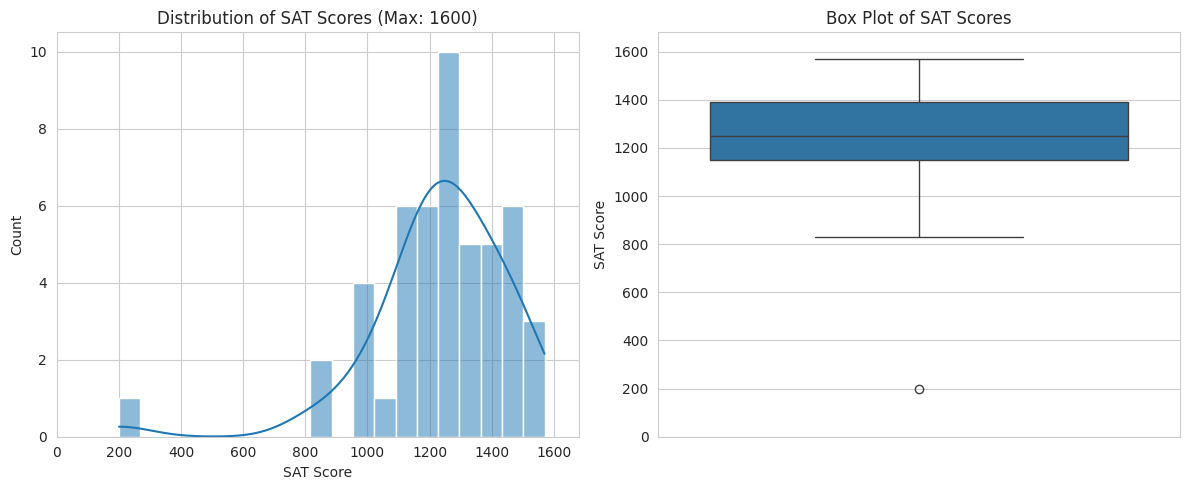


Analyzing ACT Scores...


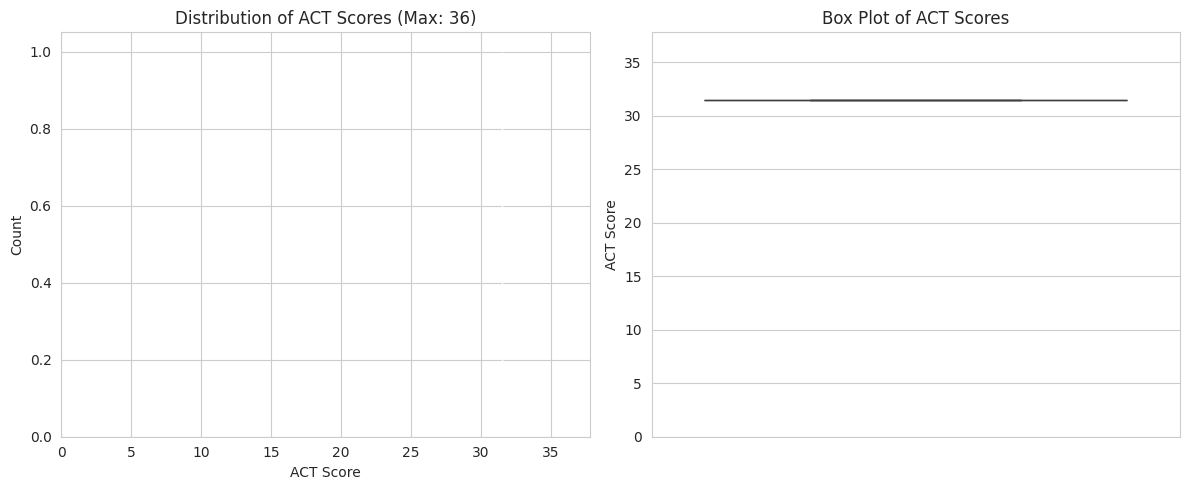


Analyzing GMAT Scores...


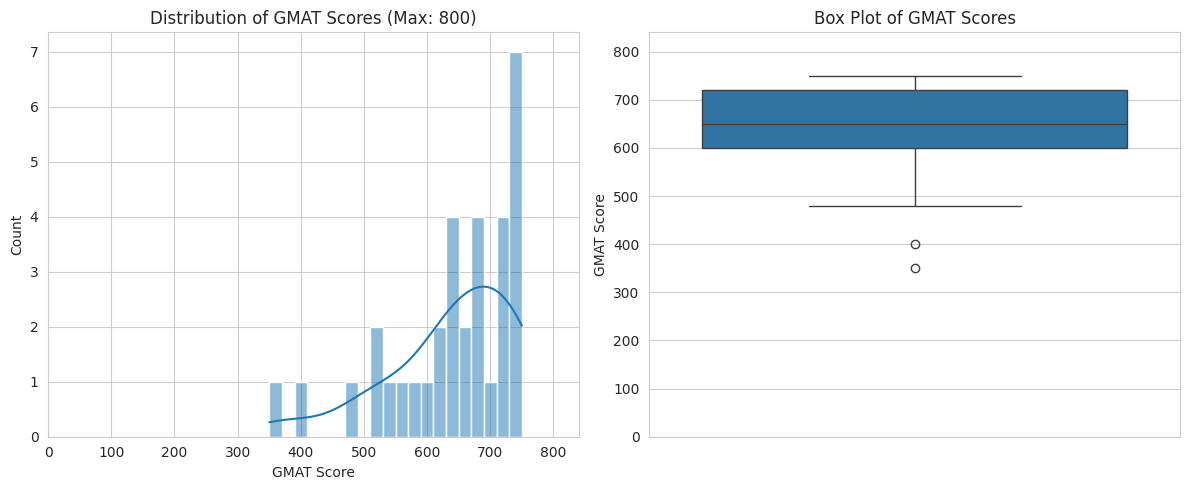

In [ ]:
# 2. Competitive Exam Score Distribution (Assuming GRE is dominant)
# 1. Check the column name and existence
print("\n--- EDA Phase 1: Step 2 - Competitive Exam Score Distribution (Split by Type) ---")

comp_exam_type_col = 'Competitive Exam'
comp_score_col = 'Total Score (Competitive Exam)'

# Find unique exam types present in the cleaned data (ignore placeholders like 'UNKNOWN')
valid_exam_types = [
    exam for exam in df_cleaned[comp_exam_type_col].unique()
    if isinstance(exam, str) and exam.upper() in MAX_SCORES
]
print(f"Found competitive exam types for plotting: {valid_exam_types}")

for exam_type in valid_exam_types:
    max_score = MAX_SCORES.get(exam_type.upper()) # Get max score for axis limits
    if max_score is None: continue # Skip if somehow not in our MAX_SCORES dict

    print(f"\nAnalyzing {exam_type} Scores...")
    exam_scores = df_cleaned[
        (df_cleaned[comp_exam_type_col].str.upper() == exam_type.upper()) &
        (df_cleaned[comp_score_col] > 0) # Filter out 0 or -2 placeholders
    ][comp_score_col]

    if not exam_scores.empty:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1) # Histogram
        sns.histplot(exam_scores.dropna(), kde=True, bins=20)
        plt.title(f'Distribution of {exam_type} Scores (Max: {max_score})')
        plt.xlabel(f'{exam_type} Score')
        plt.xlim(0, max_score * 1.05) # Set x-limit slightly above max

        plt.subplot(1, 2, 2) # Box Plot
        sns.boxplot(y=exam_scores)
        plt.title(f'Box Plot of {exam_type} Scores')
        plt.ylabel(f'{exam_type} Score')
        plt.ylim(0, max_score * 1.05) # Set y-limit slightly above max

        plt.tight_layout()
        plt.show()
    else:
        print(f"No valid {exam_type} scores > 0 found for plotting.")



--- EDA Phase 1: Step 3 - Language Exam Score Distribution ---

Analyzing TOEFL Scores...


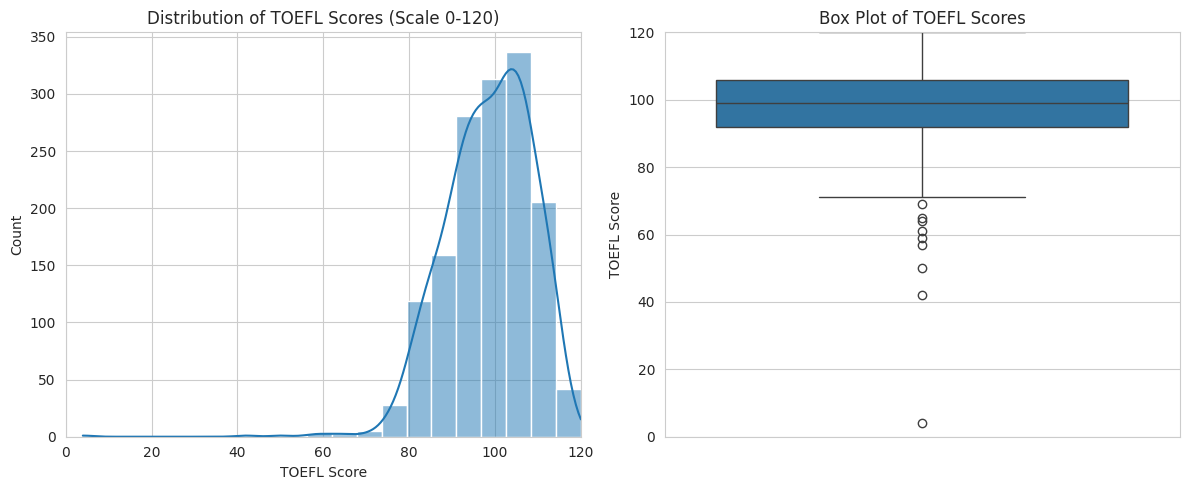


Analyzing IELTS Scores...


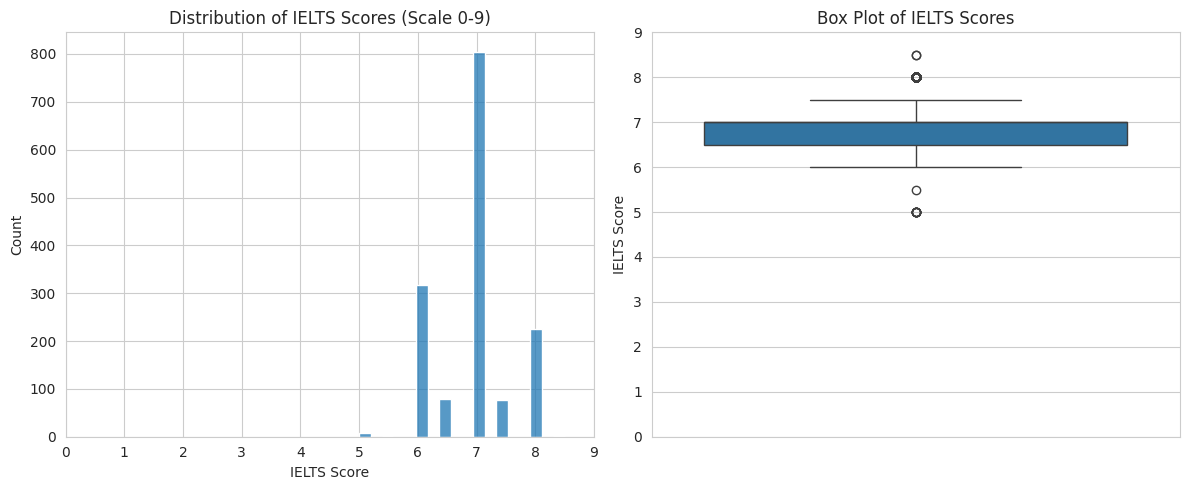

In [ ]:
# 3. Language Exam Score Distribution
print("\n--- EDA Phase 1: Step 3 - Language Exam Score Distribution ---")

# Make sure the column name is correct and handle potential case issues
lang_exam_col = 'Language Exam'
lang_score_col = 'Total Score (Language Exam)'

# --- Plotting TOEFL Scores (0-120 Scale) ---
print("\nAnalyzing TOEFL Scores...")
toefl_scores = df_cleaned[
    (df_cleaned[lang_exam_col].str.upper() == 'TOEFL') &
    (df_cleaned[lang_score_col] > 0)
][lang_score_col]

if not toefl_scores.empty:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1) # Histogram
    sns.histplot(toefl_scores.dropna(), kde=True, bins=20) # More bins for wider scale
    plt.title('Distribution of TOEFL Scores (Scale 0-120)')
    plt.xlabel('TOEFL Score')
    plt.xlim(0, 120) # Set x-axis limits to expected scale

    plt.subplot(1, 2, 2) # Box Plot
    sns.boxplot(y=toefl_scores)
    plt.title('Box Plot of TOEFL Scores')
    plt.ylabel('TOEFL Score')
    plt.ylim(0, 120) # Set y-axis limits

    plt.tight_layout()
    plt.show()
else:
    print("No valid TOEFL scores > 0 found for plotting.")

# --- Plotting IELTS Scores (0-9 Scale) ---
print("\nAnalyzing IELTS Scores...")
ielts_scores = df_cleaned[
    (df_cleaned[lang_exam_col].str.upper() == 'IELTS') &
    (df_cleaned[lang_score_col] > 0)
][lang_score_col]

if not ielts_scores.empty:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1) # Histogram
    # Bins can be adjusted; 18 allows for .5 scores, 9 for integer scores
    sns.histplot(ielts_scores.dropna(), kde=False, bins=18) # KDE might be less useful on 0-9 scale
    plt.title('Distribution of IELTS Scores (Scale 0-9)')
    plt.xlabel('IELTS Score')
    plt.xlim(0, 9) # Set x-axis limits

    plt.subplot(1, 2, 2) # Box Plot
    sns.boxplot(y=ielts_scores)
    plt.title('Box Plot of IELTS Scores')
    plt.ylabel('IELTS Score')
    plt.ylim(0, 9) # Set y-axis limits

    plt.tight_layout()
    plt.show()
else:
    print("No valid IELTS scores > 0 found for plotting.")


Plotting Categorical Feature Frequencies...


<ipython-input-16-9b06a120c1c8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_cleaned['Desired Field of Study'], order=df_cleaned['Desired Field of Study'].value_counts().nlargest(top_n).index, palette='viridis')


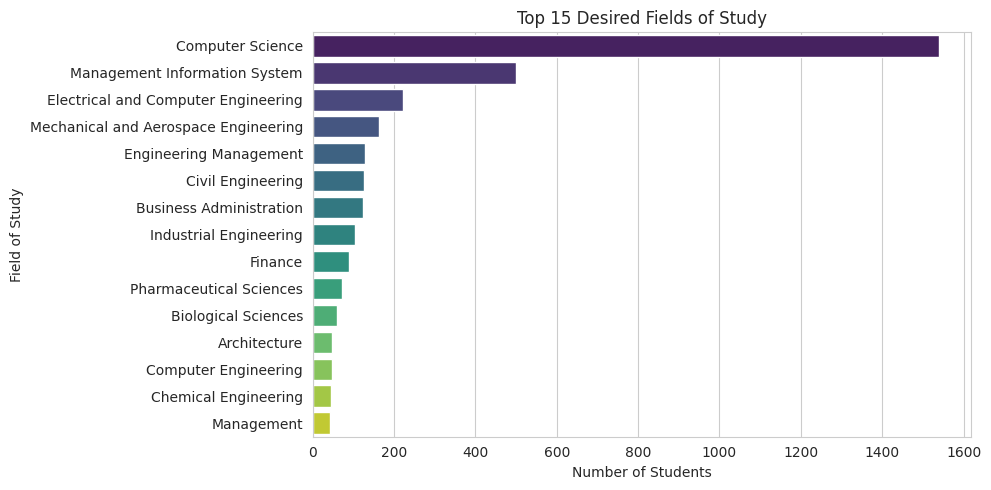

<ipython-input-16-9b06a120c1c8>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_cleaned['UG_Major'], order=df_cleaned['UG_Major'].value_counts().nlargest(top_n).index, palette='viridis')


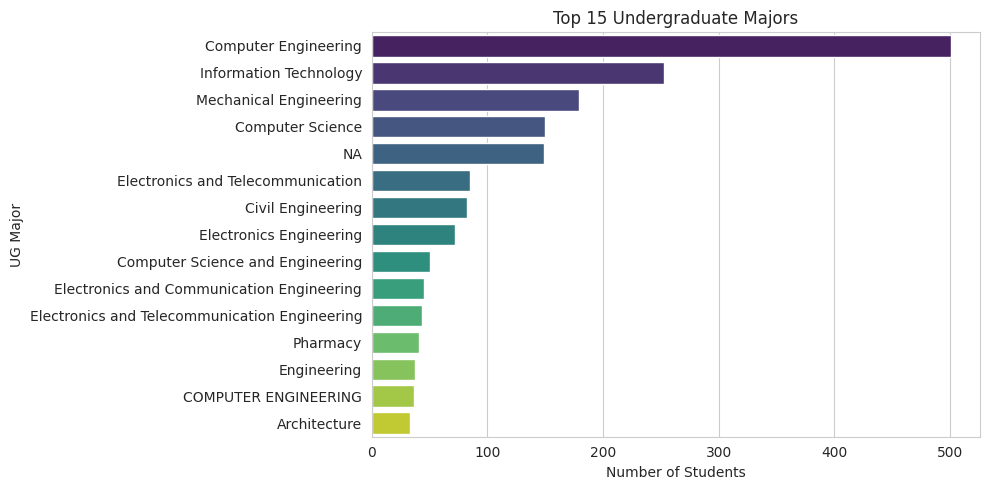

<ipython-input-16-9b06a120c1c8>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_cleaned['UG_University_Name'], order=df_cleaned['UG_University_Name'].value_counts().nlargest(top_n).index, palette='viridis')


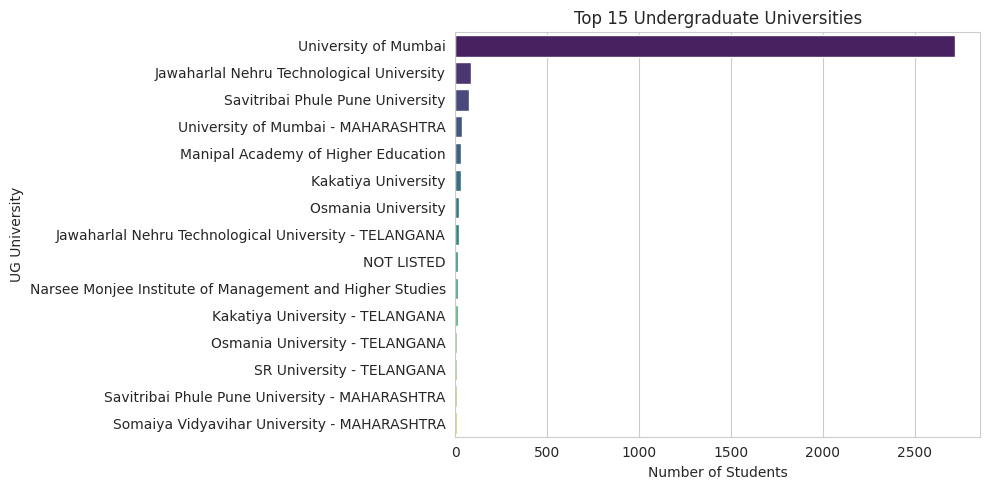

<ipython-input-16-9b06a120c1c8>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_cleaned['Language Exam'], palette='viridis')
<ipython-input-16-9b06a120c1c8>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_cleaned['Competitive Exam'], palette='viridis')


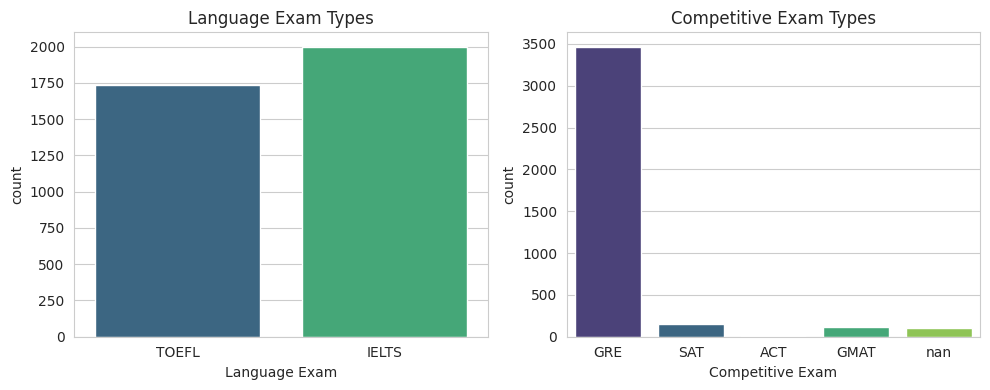

In [ ]:
# 4. Categorical Feature Frequencies
print("\nPlotting Categorical Feature Frequencies...")
top_n = 15 # Number of top categories to show

plt.figure(figsize=(10, 5))
sns.countplot(y=df_cleaned['Desired Field of Study'], order=df_cleaned['Desired Field of Study'].value_counts().nlargest(top_n).index, palette='viridis')
plt.title(f'Top {top_n} Desired Fields of Study')
plt.xlabel('Number of Students')
plt.ylabel('Field of Study')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(y=df_cleaned['UG_Major'], order=df_cleaned['UG_Major'].value_counts().nlargest(top_n).index, palette='viridis')
plt.title(f'Top {top_n} Undergraduate Majors')
plt.xlabel('Number of Students')
plt.ylabel('UG Major')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(y=df_cleaned['UG_University_Name'], order=df_cleaned['UG_University_Name'].value_counts().nlargest(top_n).index, palette='viridis')
plt.title(f'Top {top_n} Undergraduate Universities')
plt.xlabel('Number of Students')
plt.ylabel('UG University')
plt.tight_layout()
plt.show()

# Exam Types
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x=df_cleaned['Language Exam'], palette='viridis')
plt.title('Language Exam Types')
plt.subplot(1, 2, 2)
sns.countplot(x=df_cleaned['Competitive Exam'], palette='viridis')
plt.title('Competitive Exam Types')
plt.tight_layout()
plt.show()


Calculating Admitted University Frequencies...
Shape of df_exploded after reset_index: (1026, 13)


<ipython-input-17-305bf337e58c>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Admitted_University', data=df_exploded, order=df_exploded['Admitted_University'].value_counts().nlargest(top_n).index, palette='magma')


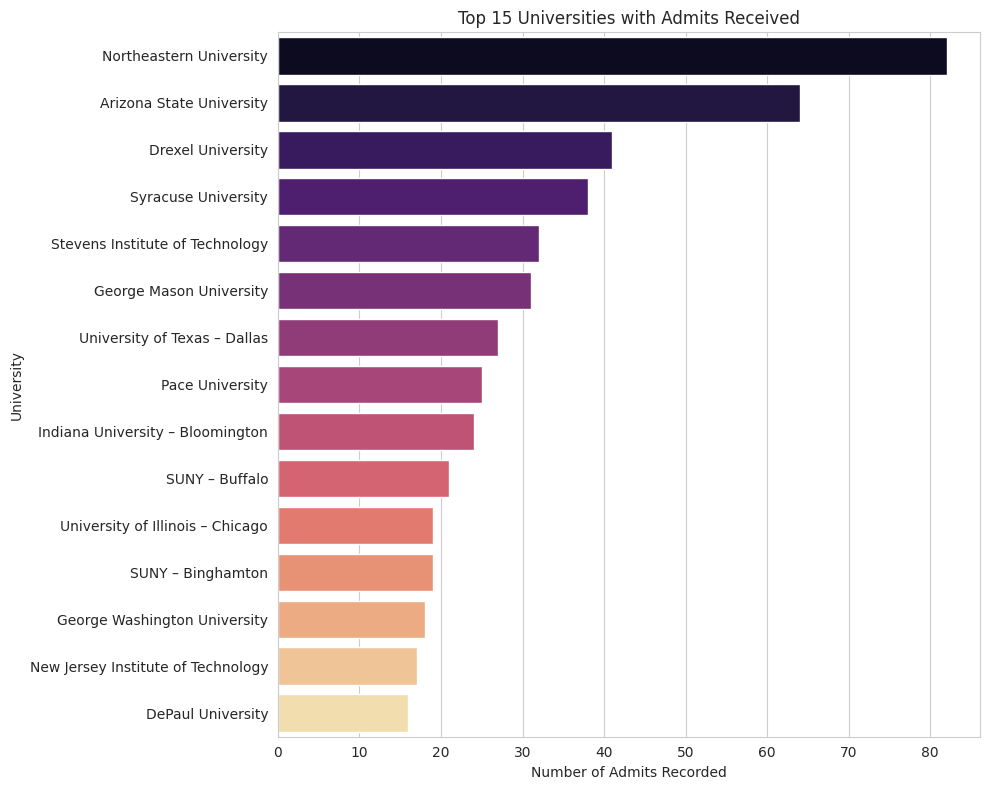

In [ ]:
# 5. Admitted University Frequency
print("\nCalculating Admitted University Frequencies...")
# Explode the list of universities into separate rows
# Ensure the column name matches the one created in preprocessing
if 'AdmitReceived_Universities' in df_cleaned.columns:
    # Explode the lists
    df_exploded = df_cleaned.explode('AdmitReceived_Universities').dropna(subset=['AdmitReceived_Universities']).copy()

    # !!! ADD THIS LINE TO FIX THE ERROR !!!
    # Reset the index after exploding because explode duplicates indices
    df_exploded.reset_index(drop=True, inplace=True)
    # -------------------------------------

    df_exploded.rename(columns={'AdmitReceived_Universities': 'Admitted_University'}, inplace=True) # Rename for clarity

    if not df_exploded.empty:
        print(f"Shape of df_exploded after reset_index: {df_exploded.shape}") # Debug print
        # Check index uniqueness again (optional)
        # print(f"Is index unique now? {!df_exploded.index.duplicated().any()}")

        plt.figure(figsize=(10, 8)) # Potentially many universities
        sns.countplot(y='Admitted_University', data=df_exploded, order=df_exploded['Admitted_University'].value_counts().nlargest(top_n).index, palette='magma')
        plt.title(f'Top {top_n} Universities with Admits Received')
        plt.xlabel('Number of Admits Recorded')
        plt.ylabel('University')
        plt.tight_layout()
        plt.show()

        # Get list of Top N universities for later use
        top_n_universities = df_exploded['Admitted_University'].value_counts().nlargest(top_n).index.tolist()
    else:
        print("No admitted universities found after exploding the list.")
        top_n_universities = [] # Initialize empty list
        df_exploded = pd.DataFrame() # Ensure df_exploded is an empty dataframe
else:
    print("Column 'AdmitReceived_Universities' not found in df_cleaned.")
    top_n_universities = []
    df_exploded = pd.DataFrame()



--- EDA Phase 2: Bivariate/Multivariate Analysis ---

Plotting Score Correlations...


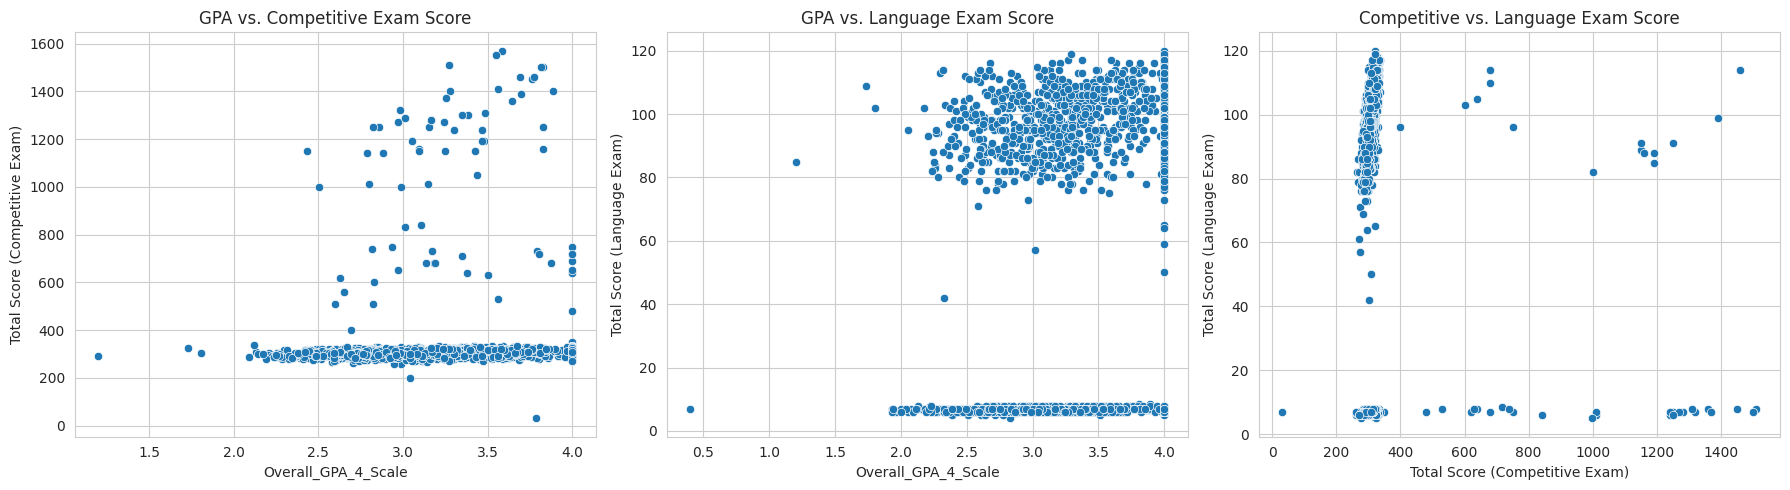

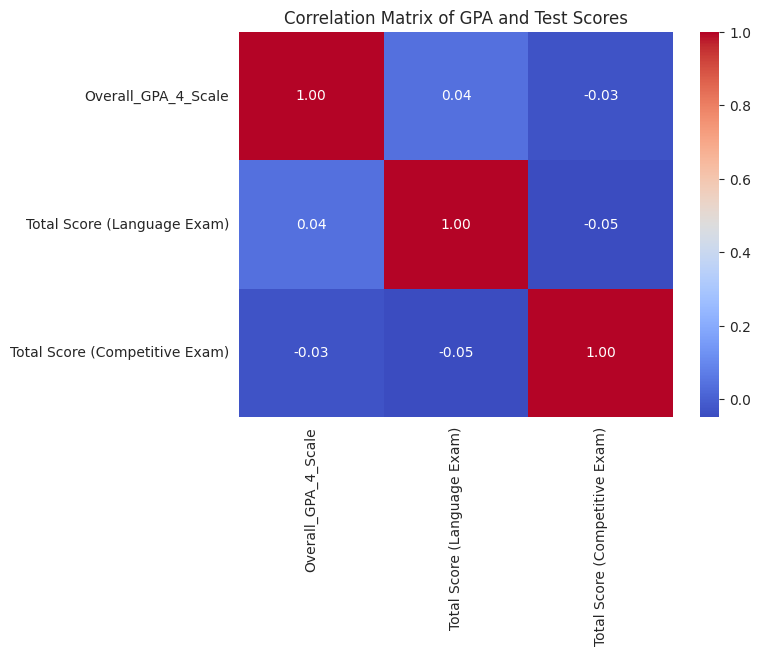

In [ ]:
# --- EDA Phase 2: Bivariate/Multivariate Analysis ---
print("\n--- EDA Phase 2: Bivariate/Multivariate Analysis ---")

# 6. Correlations between Scores
print("\nPlotting Score Correlations...")
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x='Overall_GPA_4_Scale', y='Total Score (Competitive Exam)', data=df_cleaned[df_cleaned['Total Score (Competitive Exam)'] > 0])
plt.title('GPA vs. Competitive Exam Score')

plt.subplot(1, 3, 2)
sns.scatterplot(x='Overall_GPA_4_Scale', y='Total Score (Language Exam)', data=df_cleaned[df_cleaned['Total Score (Language Exam)'] > 0])
plt.title('GPA vs. Language Exam Score')

plt.subplot(1, 3, 3)
sns.scatterplot(x='Total Score (Competitive Exam)', y='Total Score (Language Exam)', data=df_cleaned[(df_cleaned['Total Score (Competitive Exam)'] > 0) & (df_cleaned['Total Score (Language Exam)'] > 0)])
plt.title('Competitive vs. Language Exam Score')
plt.tight_layout()
plt.show()

# Correlation Heatmap
numeric_cols_for_corr = ['Overall_GPA_4_Scale', 'Total Score (Language Exam)', 'Total Score (Competitive Exam)']
# Exclude rows where scores might be 0 or negative (placeholders)
corr_data = df_cleaned[(df_cleaned['Total Score (Language Exam)'] > 0) & (df_cleaned['Total Score (Competitive Exam)'] > 0)][numeric_cols_for_corr]
if not corr_data.empty:
    correlation_matrix = corr_data.corr()
    plt.figure(figsize=(7, 5))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of GPA and Test Scores')
    plt.show()
else:
    print("Not enough valid data points for score correlation heatmap.")


--- EDA Phase 2: Step 7 - Scores by Desired Field (Split by Comp. Exam Type) ---


<ipython-input-19-57ed08f8cad7>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


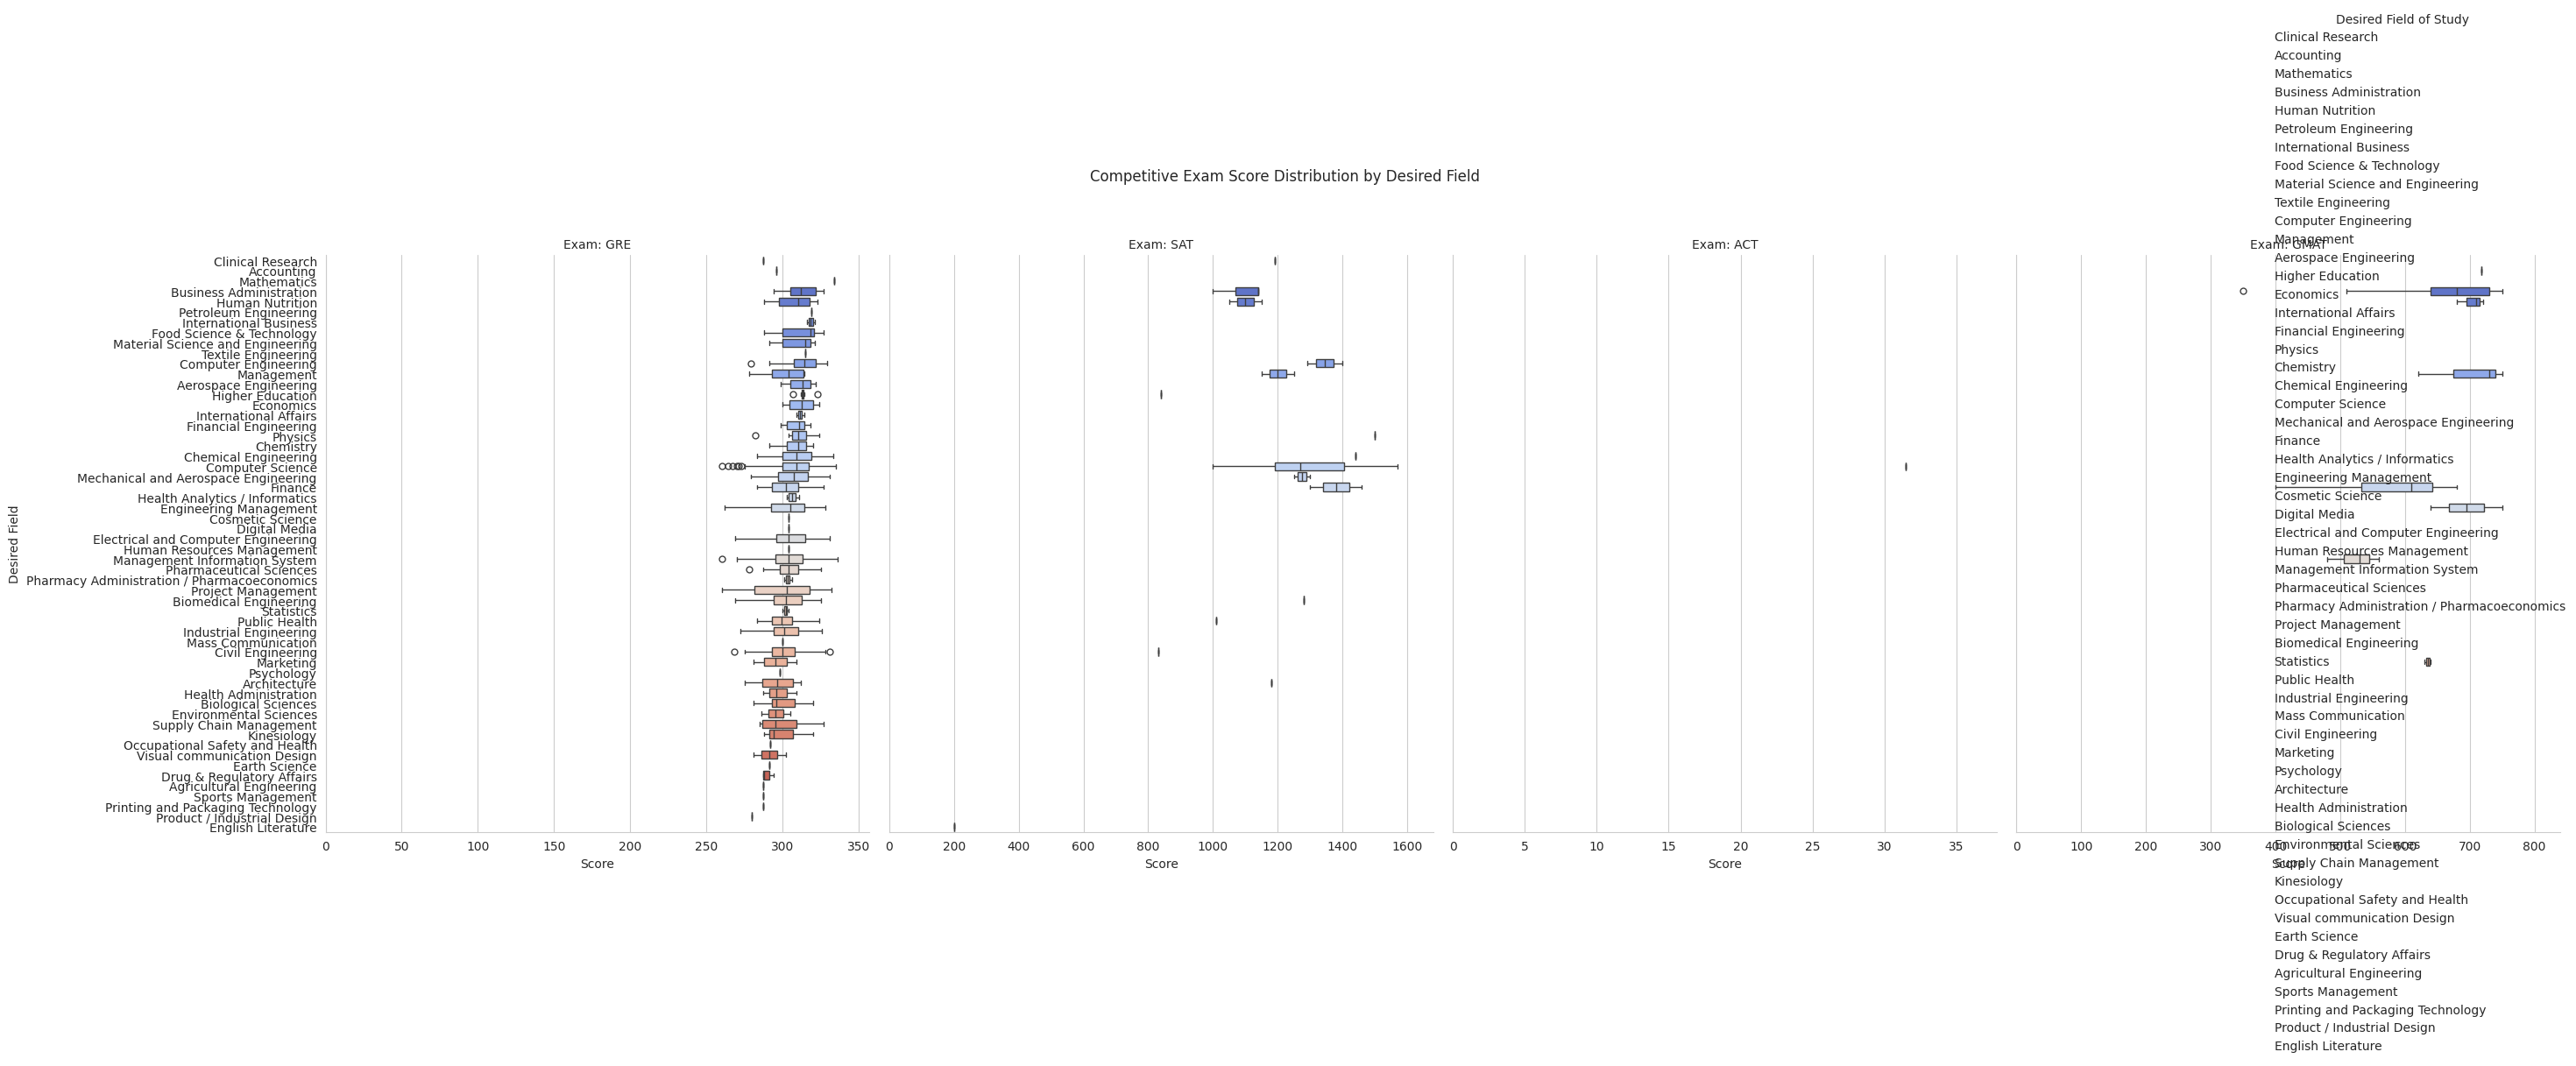

In [ ]:
# 7. Scores by Desired Field
print("\n--- EDA Phase 2: Step 7 - Scores by Desired Field (Split by Comp. Exam Type) ---")

comp_exam_type_col = 'Competitive Exam'
comp_score_col = 'Total Score (Competitive Exam)'

# Filter data to include only valid scores and known exam types
plot_data = df_cleaned[
    (df_cleaned[comp_score_col] > 0) &
    (df_cleaned[comp_exam_type_col].str.upper().isin(MAX_SCORES.keys()))
].copy()

if not plot_data.empty:
    # Use catplot for easy faceting by exam type
    g = sns.catplot(
        y='Desired Field of Study',
        x=comp_score_col,
        col=comp_exam_type_col, # Create columns for each exam type
        data=plot_data,
        kind='box',
        order=plot_data.groupby('Desired Field of Study')[comp_score_col].median().sort_values(ascending=False).index, # Optional: order fields by median score
        height=8, # Adjust height
        aspect=0.8, # Adjust aspect ratio
        palette='coolwarm',
        sharex=False # IMPORTANT: Do not share X-axis due to different scales
    )
    g.fig.suptitle('Competitive Exam Score Distribution by Desired Field', y=1.02) # Add overall title
    g.set_titles("Exam: {col_name}") # Set titles for each facet/column
    g.set_xlabels("Score")
    g.set_ylabels("Desired Field")

    # Adjust x-limits for each facet based on max score
    for ax, exam_type in zip(g.axes.flat, g.col_names):
        max_score = MAX_SCORES.get(exam_type.upper())
        if max_score:
            ax.set_xlim(0, max_score * 1.05)

    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout
    plt.show()
else:
    print("No valid competitive exam scores found for plotting by field.")



--- EDA Phase 3: University Profiling ---

Profiling Top 15 Admitted Universities...


<ipython-input-20-fcf7f8e1d439>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='Admitted_University', x='Overall_GPA_4_Scale', data=df_exploded_top_n, order=order, palette='YlGnBu')


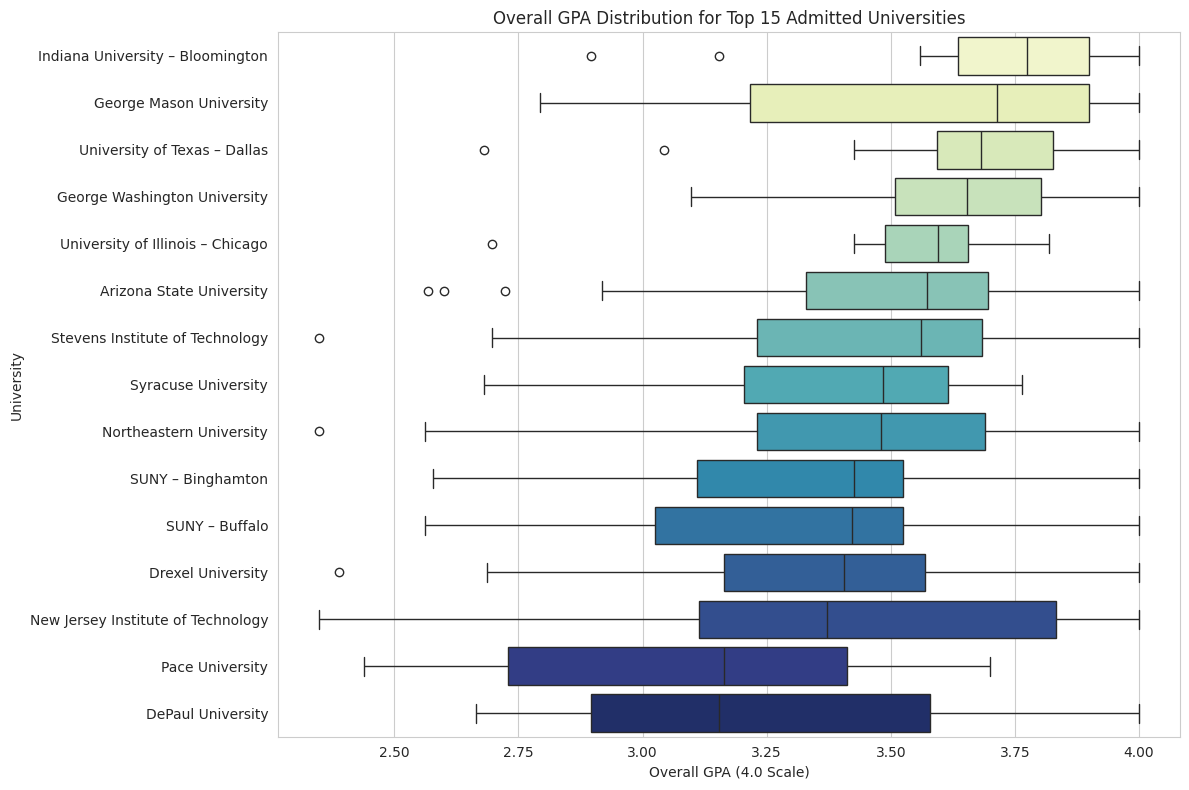

In [ ]:
# --- EDA Phase 3: University Profiling ---
print("\n--- EDA Phase 3: University Profiling ---")

if not df_exploded.empty and top_n_universities:
    print(f"\nProfiling Top {len(top_n_universities)} Admitted Universities...")
    # Filter the exploded data for only the top N universities
    df_exploded_top_n = df_exploded[df_exploded['Admitted_University'].isin(top_n_universities)]

    # 9. GPA Profiles of Universities
    plt.figure(figsize=(12, 8))
    # Order universities by median GPA
    order = df_exploded_top_n.groupby('Admitted_University')['Overall_GPA_4_Scale'].median().sort_values(ascending=False).index
    sns.boxplot(y='Admitted_University', x='Overall_GPA_4_Scale', data=df_exploded_top_n, order=order, palette='YlGnBu')
    plt.title(f'Overall GPA Distribution for Top {len(top_n_universities)} Admitted Universities')
    plt.xlabel('Overall GPA (4.0 Scale)')
    plt.ylabel('University')
    plt.tight_layout()
    plt.show()



--- EDA Phase 3: Step 10 - Competitive Exam Score Profiles of Universities (Split by Type) ---
Found competitive exam types for top N uni profiling: ['GRE', 'SAT', 'GMAT']

Analyzing GRE Score Profiles for Top Universities...


<ipython-input-21-ad630b9d9008>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='Admitted_University', x=comp_score_col, data=df_exam_profiles, order=order, palette='YlGnBu')


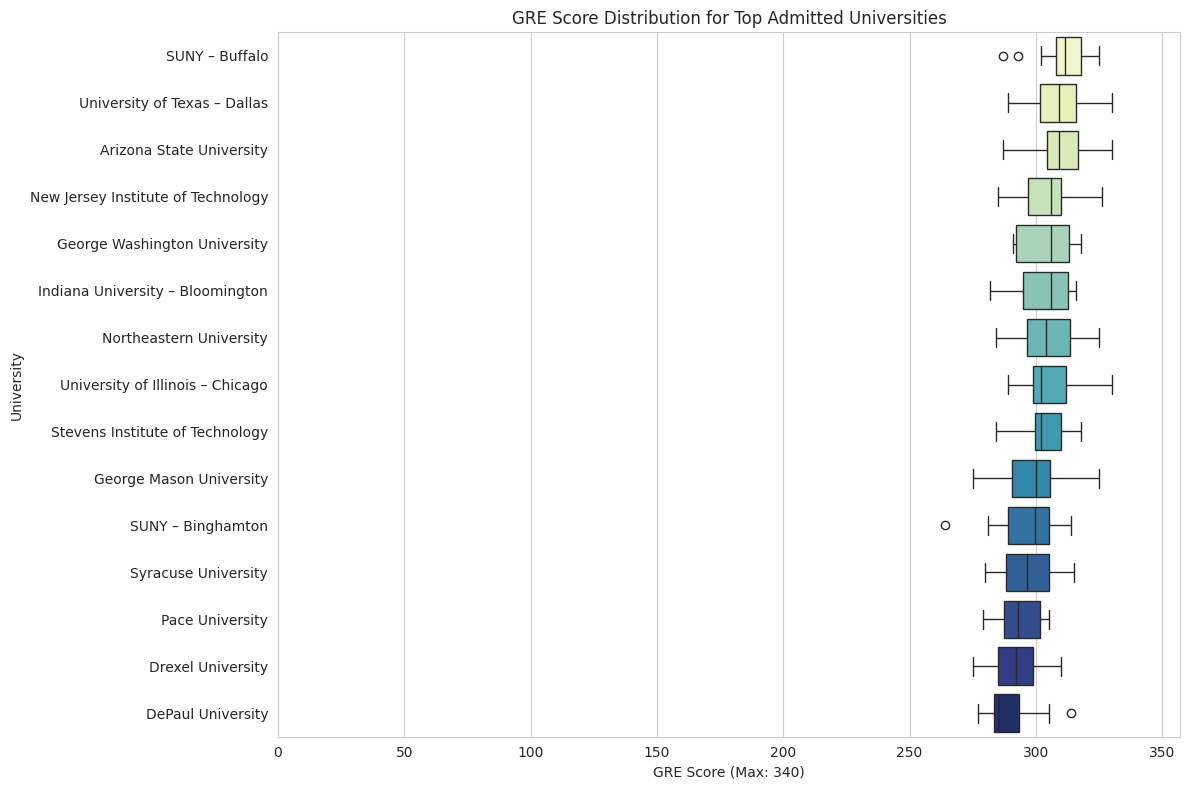


Analyzing SAT Score Profiles for Top Universities...


<ipython-input-21-ad630b9d9008>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='Admitted_University', x=comp_score_col, data=df_exam_profiles, order=order, palette='YlGnBu')


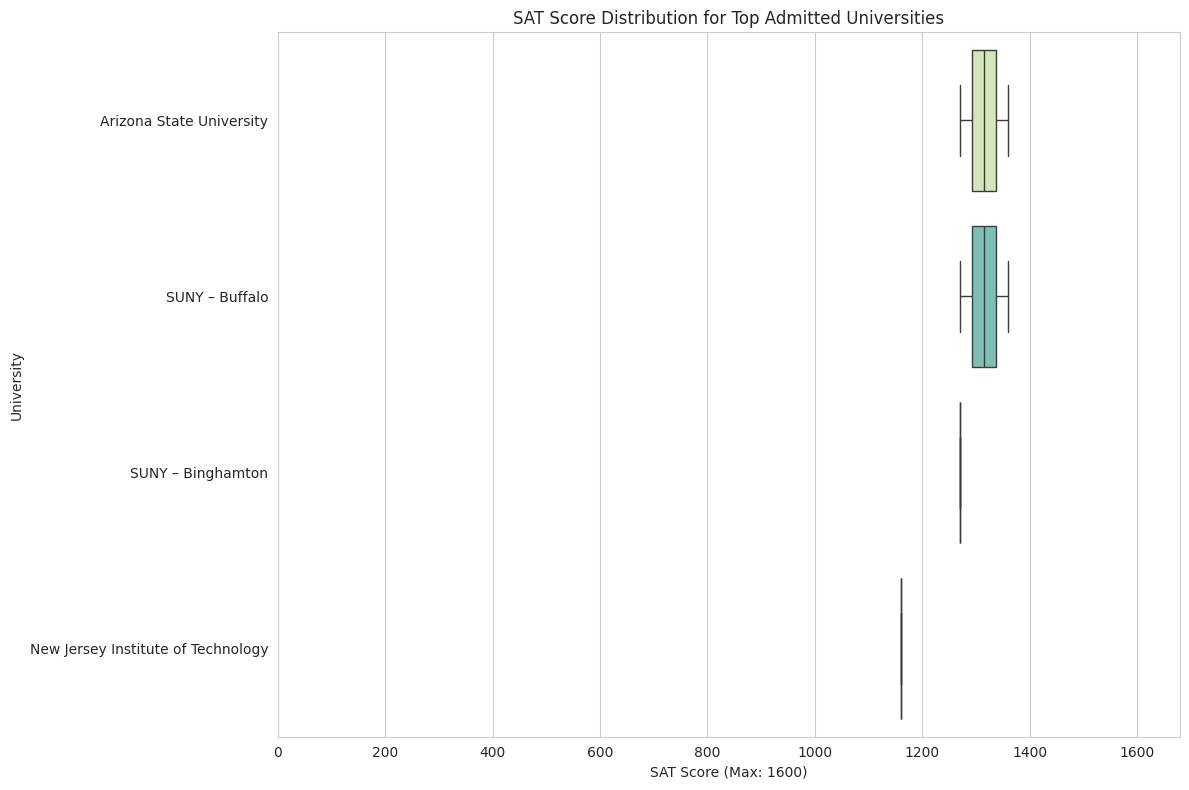


Analyzing GMAT Score Profiles for Top Universities...


<ipython-input-21-ad630b9d9008>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='Admitted_University', x=comp_score_col, data=df_exam_profiles, order=order, palette='YlGnBu')


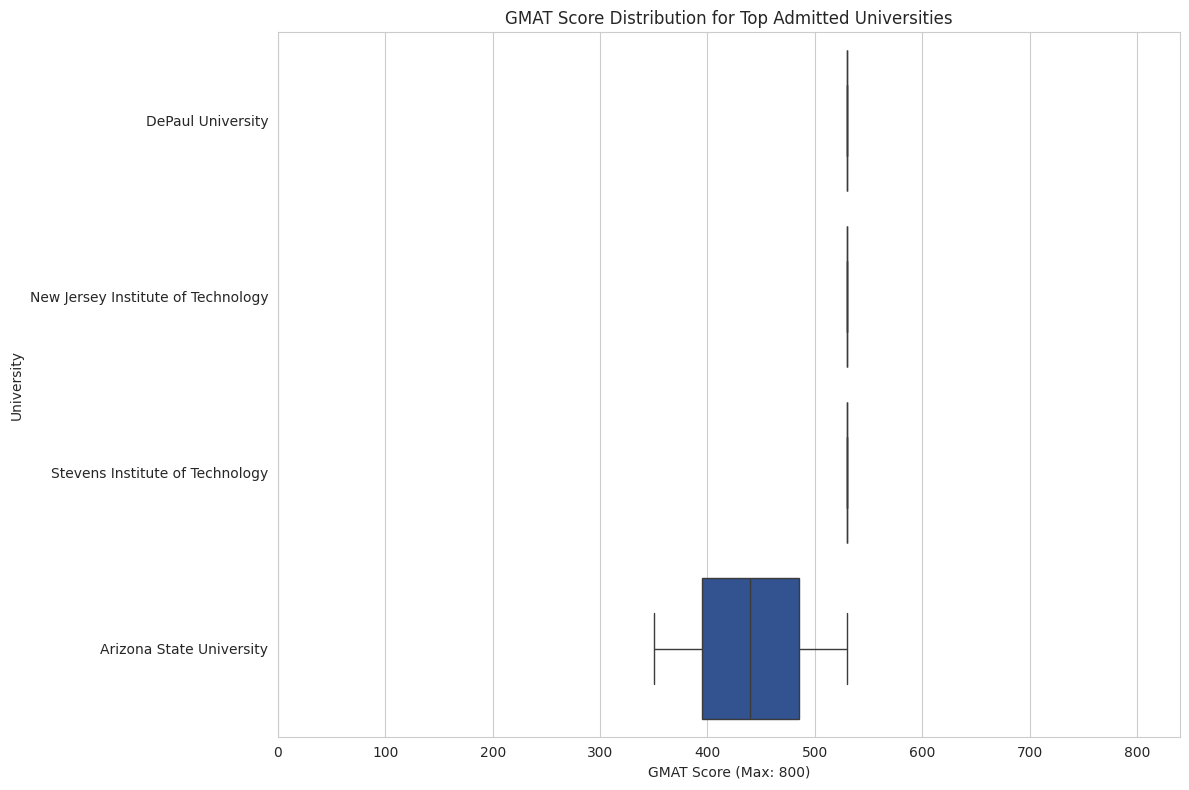

In [ ]:
# 10. Competitive Exam Score Profiles of Universities
print("\n--- EDA Phase 3: Step 10 - Competitive Exam Score Profiles of Universities (Split by Type) ---")

# Ensure df_exploded_top_n exists from previous steps
if 'df_exploded_top_n' in locals() and not df_exploded_top_n.empty:

    comp_exam_type_col = 'Competitive Exam'
    comp_score_col = 'Total Score (Competitive Exam)'

    valid_exam_types_in_top = [
        exam for exam in df_exploded_top_n[comp_exam_type_col].unique()
        if isinstance(exam, str) and exam.upper() in MAX_SCORES
    ]
    print(f"Found competitive exam types for top N uni profiling: {valid_exam_types_in_top}")

    for exam_type in valid_exam_types_in_top:
        max_score = MAX_SCORES.get(exam_type.upper())
        if max_score is None: continue

        print(f"\nAnalyzing {exam_type} Score Profiles for Top Universities...")
        df_exam_profiles = df_exploded_top_n[
            (df_exploded_top_n[comp_exam_type_col].str.upper() == exam_type.upper()) &
            (df_exploded_top_n[comp_score_col] > 0)
        ].copy()

        if not df_exam_profiles.empty:
            plt.figure(figsize=(12, 8))
            # Order universities by median score for this exam type
            order = df_exam_profiles.groupby('Admitted_University')[comp_score_col].median().sort_values(ascending=False).index
            sns.boxplot(y='Admitted_University', x=comp_score_col, data=df_exam_profiles, order=order, palette='YlGnBu')
            plt.title(f'{exam_type} Score Distribution for Top Admitted Universities')
            plt.xlabel(f'{exam_type} Score (Max: {max_score})')
            plt.ylabel('University')
            plt.xlim(0, max_score * 1.05) # Set appropriate x-axis limits
            plt.tight_layout()
            plt.show()
        else:
            print(f"No valid {exam_type} scores > 0 found for the top universities.")
else:
    print("\nSkipping University Competitive Score Profiles as df_exploded_top_n is not available or empty.")


--- EDA Phase 3: Step 11 - Language Exam Score Profiles of Universities ---

Analyzing TOEFL Score Profiles for Top Universities...


<ipython-input-22-11ed2b9e8468>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='Admitted_University', x=lang_score_col, data=df_toefl_profiles, order=order_toefl, palette='YlGnBu')


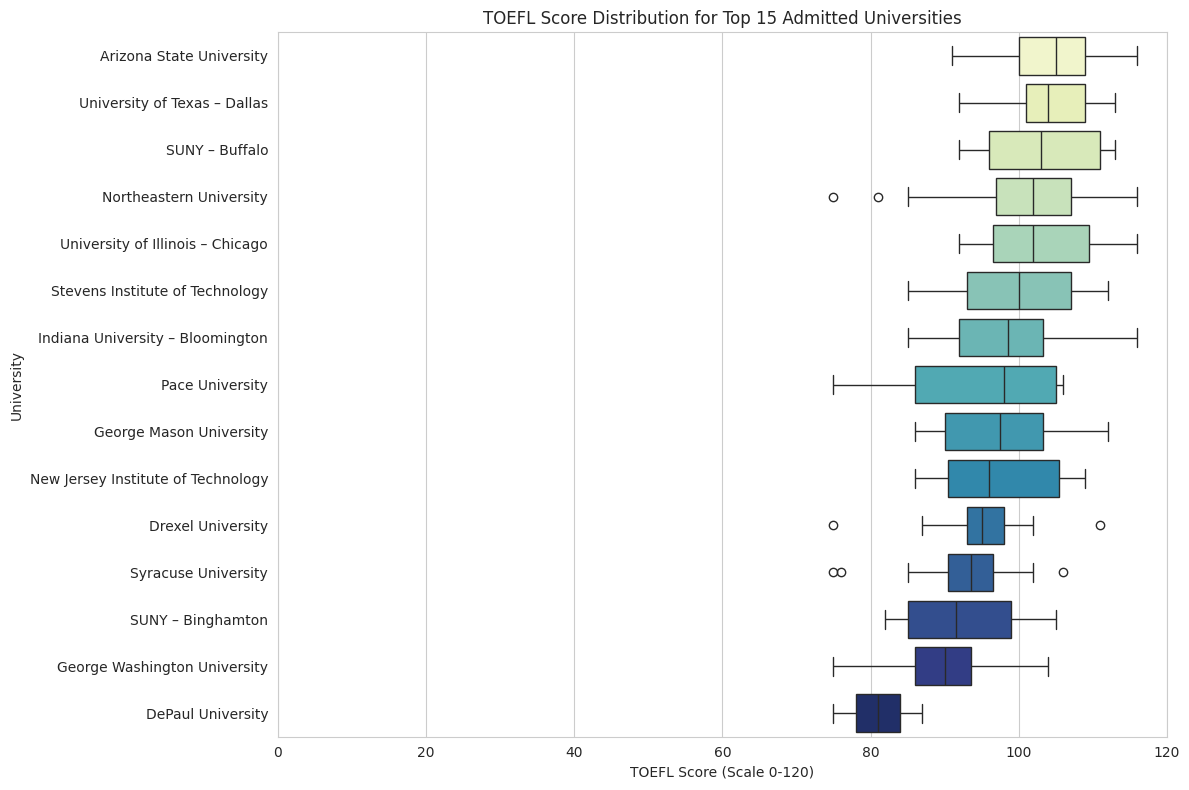


Analyzing IELTS Score Profiles for Top Universities...


<ipython-input-22-11ed2b9e8468>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='Admitted_University', x=lang_score_col, data=df_ielts_profiles, order=order_ielts, palette='YlOrRd') # Different palette


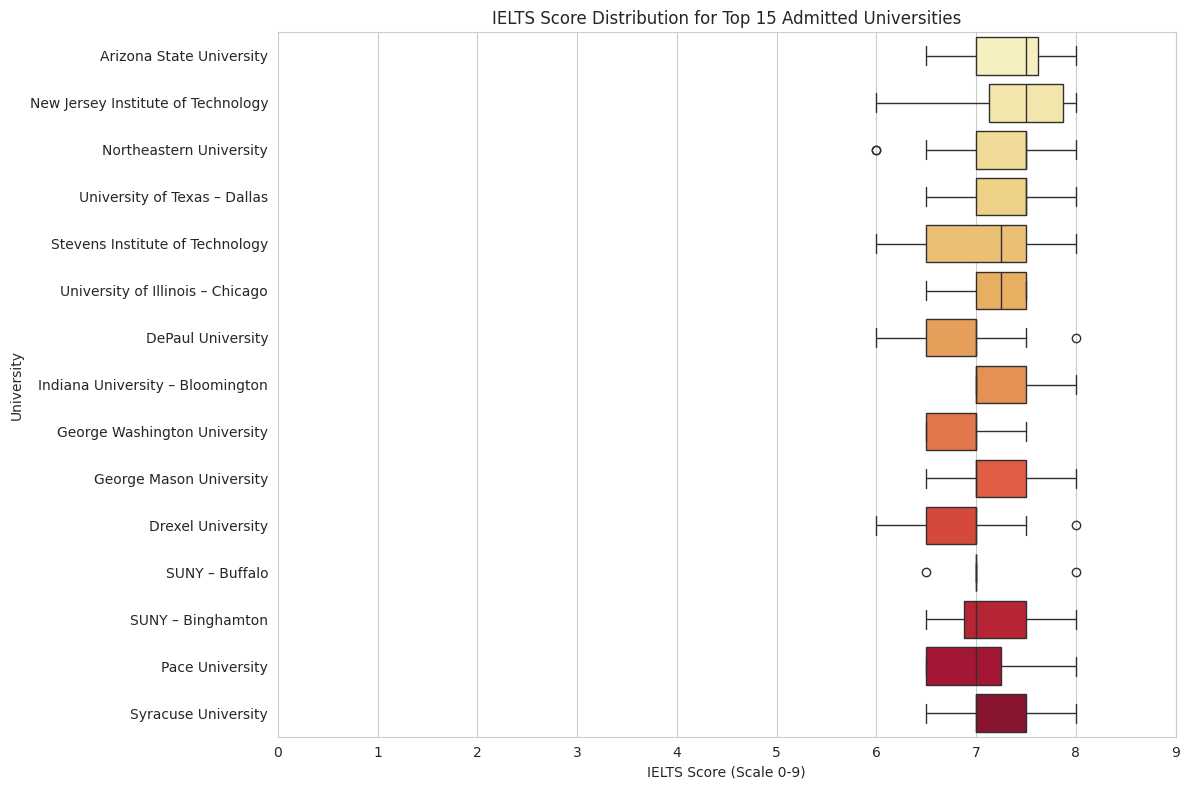

In [ ]:
print("\n--- EDA Phase 3: Step 11 - Language Exam Score Profiles of Universities ---")

# Make sure df_exploded_top_n exists and is not empty
if 'df_exploded_top_n' in locals() and not df_exploded_top_n.empty:

    lang_exam_col = 'Language Exam'
    lang_score_col = 'Total Score (Language Exam)'

    # --- 11a. TOEFL Score Profiles of Universities (0-120 Scale) ---
    print("\nAnalyzing TOEFL Score Profiles for Top Universities...")
    df_toefl_profiles = df_exploded_top_n[
        (df_exploded_top_n[lang_exam_col].str.upper() == 'TOEFL') &
        (df_exploded_top_n[lang_score_col] > 0)
    ].copy() # Use .copy() to avoid potential SettingWithCopyWarning

    if not df_toefl_profiles.empty:
        plt.figure(figsize=(12, 8))
        # Order universities by median TOEFL score
        order_toefl = df_toefl_profiles.groupby('Admitted_University')[lang_score_col].median().sort_values(ascending=False).index
        sns.boxplot(y='Admitted_University', x=lang_score_col, data=df_toefl_profiles, order=order_toefl, palette='YlGnBu')
        plt.title(f'TOEFL Score Distribution for Top {len(order_toefl)} Admitted Universities') # Adjust N based on actual data
        plt.xlabel('TOEFL Score (Scale 0-120)')
        plt.ylabel('University')
        plt.xlim(0, 120) # Set appropriate x-axis limits
        plt.tight_layout()
        plt.show()
    else:
        print("No valid TOEFL scores > 0 found for the top universities.")


    # --- 11b. IELTS Score Profiles of Universities (0-9 Scale) ---
    print("\nAnalyzing IELTS Score Profiles for Top Universities...")
    df_ielts_profiles = df_exploded_top_n[
        (df_exploded_top_n[lang_exam_col].str.upper() == 'IELTS') &
        (df_exploded_top_n[lang_score_col] > 0)
    ].copy() # Use .copy()

    if not df_ielts_profiles.empty:
        plt.figure(figsize=(12, 8))
        # Order universities by median IELTS score
        order_ielts = df_ielts_profiles.groupby('Admitted_University')[lang_score_col].median().sort_values(ascending=False).index
        sns.boxplot(y='Admitted_University', x=lang_score_col, data=df_ielts_profiles, order=order_ielts, palette='YlOrRd') # Different palette
        plt.title(f'IELTS Score Distribution for Top {len(order_ielts)} Admitted Universities') # Adjust N
        plt.xlabel('IELTS Score (Scale 0-9)')
        plt.ylabel('University')
        plt.xlim(0, 9) # Set appropriate x-axis limits
        plt.tight_layout()
        plt.show()
    else:
        print("No valid IELTS scores > 0 found for the top universities.")

else:
    print("\nSkipping University Language Profiles as df_exploded_top_n is not available or empty.")



--- EDA Phase 3: Step 12 - Combined Score View (Split by Comp. Exam Type) ---

Plotting GPA vs GRE Score for Top Universities...


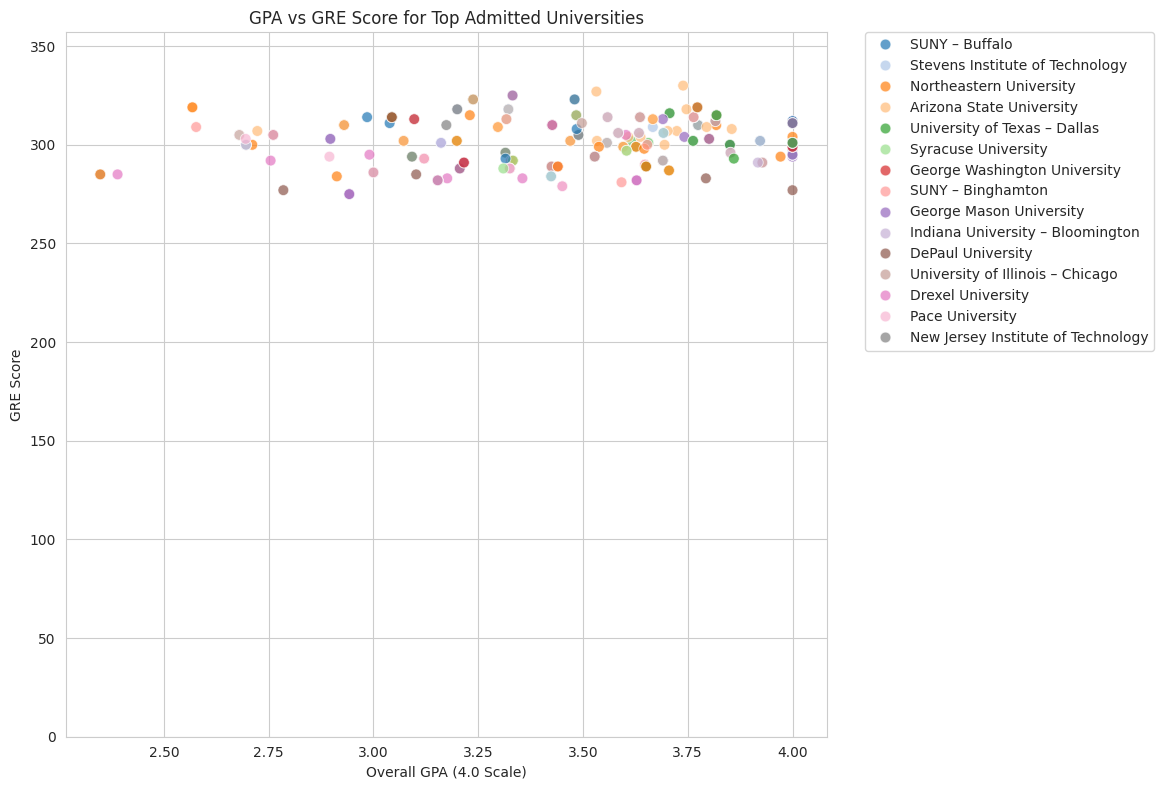


Plotting GPA vs SAT Score for Top Universities...


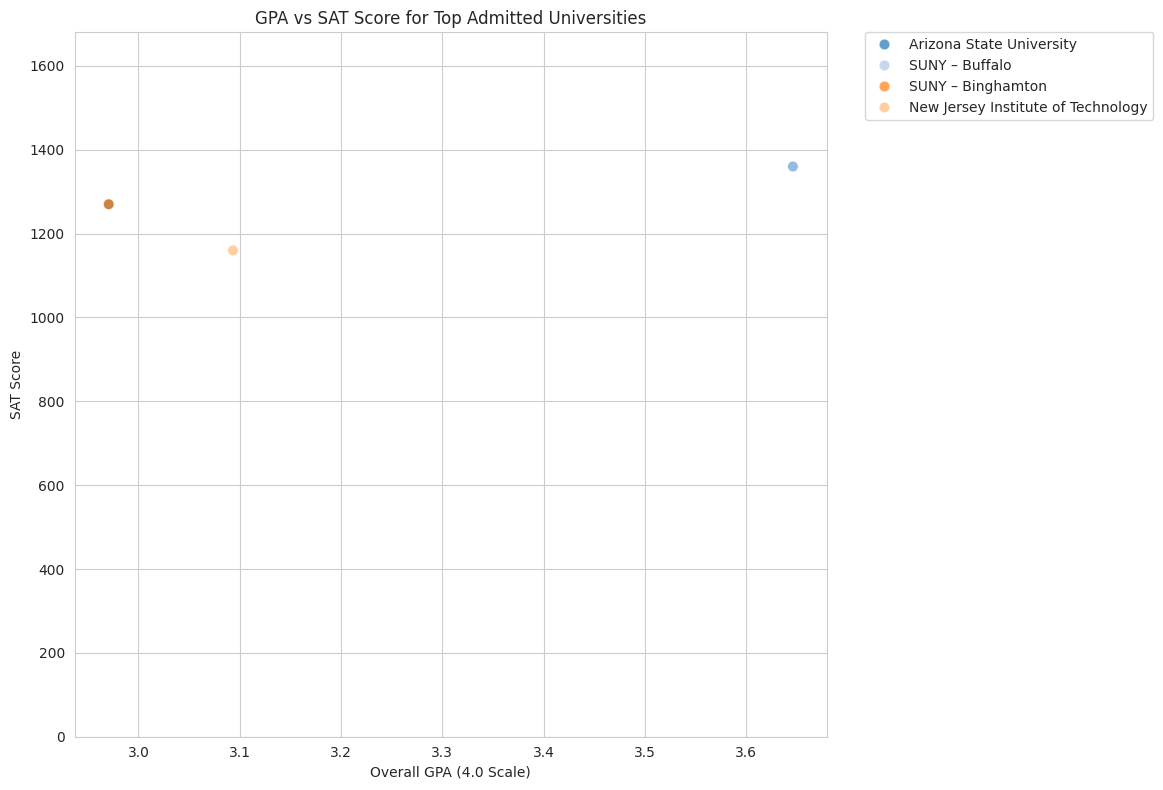


Plotting GPA vs GMAT Score for Top Universities...


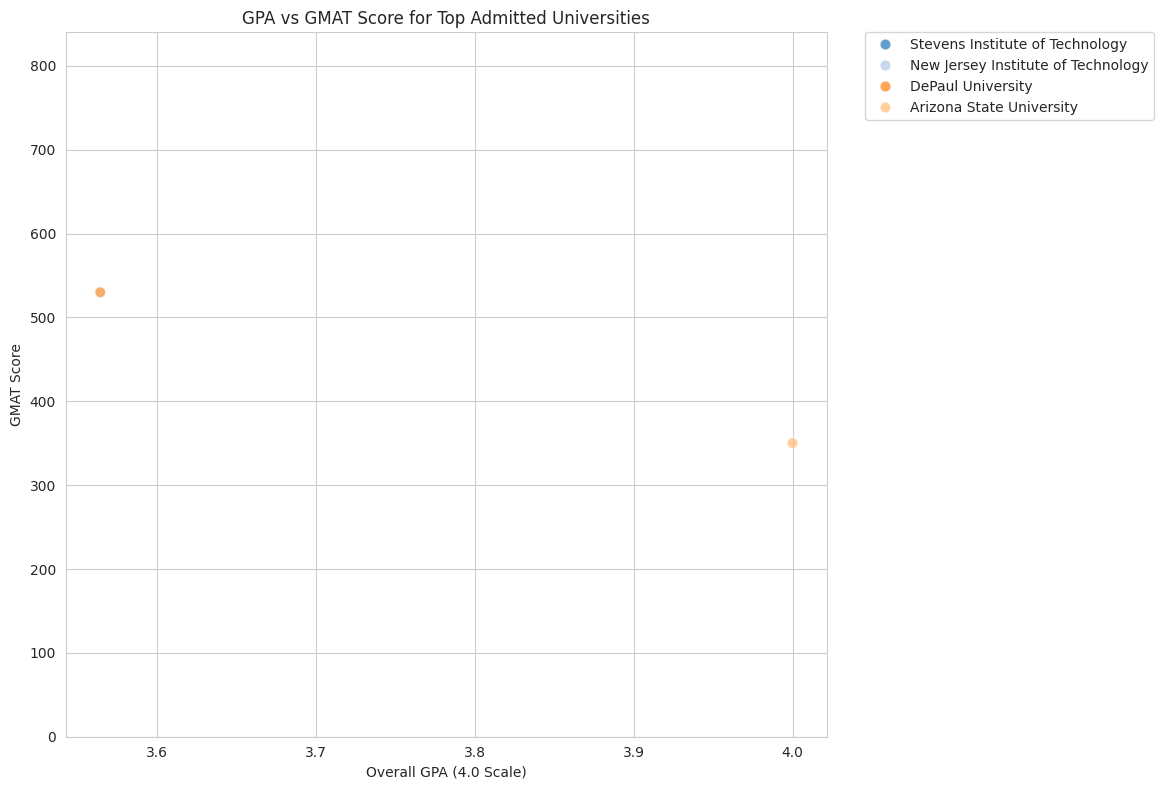

In [ ]:
# --- EDA Phase 3: Step 12 - Combined Score View for Universities (Split by Comp. Exam Type) ---
print("\n--- EDA Phase 3: Step 12 - Combined Score View (Split by Comp. Exam Type) ---")

# Creating separate plots for each exam type is clearer due to scale differences

if 'df_exploded_top_n' in locals() and not df_exploded_top_n.empty:
    comp_exam_type_col = 'Competitive Exam'
    comp_score_col = 'Total Score (Competitive Exam)'
    gpa_col = 'Overall_GPA_4_Scale'

    valid_exam_types_in_top = [
        exam for exam in df_exploded_top_n[comp_exam_type_col].unique()
        if isinstance(exam, str) and exam.upper() in MAX_SCORES
    ]

    for exam_type in valid_exam_types_in_top:
        max_score = MAX_SCORES.get(exam_type.upper())
        if max_score is None: continue

        print(f"\nPlotting GPA vs {exam_type} Score for Top Universities...")
        df_exam_scatter = df_exploded_top_n[
            (df_exploded_top_n[comp_exam_type_col].str.upper() == exam_type.upper()) &
            (df_exploded_top_n[comp_score_col] > 0)
        ].copy()

        if not df_exam_scatter.empty:
            plt.figure(figsize=(14, 8))
            sns.scatterplot(
                x=gpa_col,
                y=comp_score_col,
                hue='Admitted_University',
                data=df_exam_scatter,
                palette='tab20',
                s=60,
                alpha=0.7
            )
            plt.title(f'GPA vs {exam_type} Score for Top Admitted Universities')
            plt.xlabel('Overall GPA (4.0 Scale)')
            plt.ylabel(f'{exam_type} Score')
            plt.ylim(0, max_score * 1.05) # Set y-limit based on exam type
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            plt.tight_layout(rect=[0, 0, 0.85, 1])
            plt.show()
        else:
            print(f"No valid {exam_type} scores > 0 found for scatter plot.")
else:
    print("\nSkipping Combined Score View as df_exploded_top_n is not available or empty.")

In [ ]:
# --- EDA Phase 3: Step 13 - Granular Quantitative Profiles ---
print("\n--- EDA Phase 3: Step 13 - Granular Quantitative Profiles (Uni, Field, Degree, split Comp/Lang Stats) ---")

if 'df_exploded_top_n' in locals() and not df_exploded_top_n.empty:
    # --- Define Column Names ---
    uni_col = 'Admitted_University'
    field_col = 'Desired Field of Study'
    # *** ADDED: Define the column for desired degree level ***
    # *** Please verify 'Future Desired Degree' is the correct column name ***
    degree_level_col = 'Future Desired Degree'

    comp_exam_type_col = 'Competitive Exam'
    comp_score_col = 'Total Score (Competitive Exam)'
    lang_exam_col = 'Language Exam'
    lang_score_col = 'Total Score (Language Exam)'
    gpa_col = 'Overall_GPA_4_Scale'

    # --- Check required columns exist ---
    required_cols = [uni_col, field_col, degree_level_col, comp_exam_type_col, lang_exam_col, gpa_col, comp_score_col, lang_score_col]
    missing_cols = [col for col in required_cols if col not in df_exploded_top_n.columns]
    if missing_cols:
        print(f"ERROR: Missing required columns: {missing_cols}. Skipping granular stats.")
    else:
        # --- Filter data for known competitive exam types ---
        # Use .copy() to avoid SettingWithCopyWarning on chained assignments
        df_exploded_filtered = df_exploded_top_n[
            df_exploded_top_n[comp_exam_type_col].str.upper().isin(MAX_SCORES.keys())
        ].copy()

        # Optional: Fill NaNs in grouping columns if needed for groupby/joining
        df_exploded_filtered[field_col] = df_exploded_filtered[field_col].fillna('Unknown')
        df_exploded_filtered[degree_level_col] = df_exploded_filtered[degree_level_col].fillna('Unknown')
        df_exploded_filtered[comp_exam_type_col] = df_exploded_filtered[comp_exam_type_col].fillna('Unknown')
        df_exploded_filtered[lang_exam_col] = df_exploded_filtered[lang_exam_col].fillna('Unknown')


        # --- Define base grouping keys ---
        base_grouping_keys = [uni_col, field_col, degree_level_col]

        # --- Define safe aggregation functions ---
        def safe_mean(x): return x[x > 0].mean()
        def safe_median(x): return x[x > 0].median()
        def safe_min(x): return x[x > 0].min()
        def safe_max(x): return x[x > 0].max()
        def safe_std(x): return x[x > 0].std()
        def safe_count(x): return x[x > 0].count() # Count only valid scores > 0

        # --- 1. Calculate GPA Stats & Overall Count ---
        print("Calculating GPA stats and counts...")
        summary_stats_gpa_count = df_exploded_filtered.groupby(base_grouping_keys).agg(
            Avg_GPA=(gpa_col, 'mean'),
            Median_GPA=(gpa_col, 'median'),
            Count=(gpa_col, 'size') # Total admits for this uni/field/degree combo
        )

        # --- 2. Calculate Language Stats (Split by Type) ---
        print("Calculating split Language stats...")
        lang_grouping_keys = base_grouping_keys + [lang_exam_col]
        df_lang_filtered = df_exploded_filtered[df_exploded_filtered[lang_score_col] > 0]

        if not df_lang_filtered.empty:
            summary_stats_lang = df_lang_filtered.groupby(lang_grouping_keys).agg(
                Avg_Lang=(lang_score_col, 'mean'),
                Median_Lang=(lang_score_col, 'median'),
                Min_Lang=(lang_score_col, 'min'),
                Max_Lang=(lang_score_col, 'max'),
                Std_Lang=(lang_score_col, 'std'),
                Count_Lang=(lang_score_col, 'size') # Count for this specific language test
            )
            lang_stats_unstacked = summary_stats_lang.unstack(level=lang_exam_col) # Pivot Lang Exam
            lang_stats_unstacked.columns = ['_'.join(col).strip() for col in lang_stats_unstacked.columns.values]
        else:
            print("No valid language scores > 0 found.")
            lang_stats_unstacked = pd.DataFrame(index=summary_stats_gpa_count.index) # Empty DF with matching index levels


        # --- 3. Calculate Competitive Stats (Split by Type) ---
        print("Calculating split Competitive Exam stats...")
        comp_grouping_keys = base_grouping_keys + [comp_exam_type_col]
        df_comp_filtered = df_exploded_filtered[df_exploded_filtered[comp_score_col] > 0]

        if not df_comp_filtered.empty:
            summary_stats_comp = df_comp_filtered.groupby(comp_grouping_keys).agg(
                Avg_Comp=(comp_score_col, 'mean'),
                Median_Comp=(comp_score_col, 'median'),
                Min_Comp=(comp_score_col, 'min'),
                Max_Comp=(comp_score_col, 'max'),
                Std_Comp=(comp_score_col, 'std'),
                Count_Comp=(comp_score_col, 'size') # Count for this specific comp exam
            )
            comp_stats_unstacked = summary_stats_comp.unstack(level=comp_exam_type_col) # Pivot Comp Exam
            comp_stats_unstacked.columns = ['_'.join(col).strip() for col in comp_stats_unstacked.columns.values]
        else:
            print("No valid competitive scores > 0 found.")
            comp_stats_unstacked = pd.DataFrame(index=summary_stats_gpa_count.index) # Empty DF


        # --- 4. Join all stats together ---
        print("Joining statistics...")
        summary_stats_final = summary_stats_gpa_count.join(
            [lang_stats_unstacked, comp_stats_unstacked], how='left' # Use left join to keep all base groups
        )

        # --- 5. Final Touches ---
        summary_stats_final = summary_stats_final.round(2) # Round all stats
        summary_stats_final = summary_stats_final.sort_index() # Sort by multi-index

        print(f"\nFinal Granular Summary Statistics:")
        # Display with options to see all rows/columns if needed
        with pd.option_context('display.max_rows', 100, 'display.max_columns', None): # Show more rows
            print(summary_stats_final)

        # --- Optional: Save the final table to Excel ---
        # excel_output_granular = 'university_stats_summary_granular.xlsx'
        # print(f"\nSaving granular summary to {excel_output_granular}...")
        # summary_stats_final.to_excel(excel_output_granular, index=True, merge_cells=True)
        # print("Save complete.")

else:
    print("\nSkipping Granular Quantitative Profiles as df_exploded_top_n is not available or empty.")

# print("\n--- EDA Finished ---") # Move this to the very end of all EDA steps


--- EDA Phase 3: Step 13 - Granular Quantitative Profiles (Uni, Field, Degree, split Comp/Lang Stats) ---
Calculating GPA stats and counts...
Calculating split Language stats...
Calculating split Competitive Exam stats...
Joining statistics...

Final Granular Summary Statistics:
                                                                                               Avg_GPA  \
Admitted_University                Desired Field of Study               Future Desired Degree            
Arizona State University           Architecture                         Masters                   3.09   
                                   Business Administration              Masters                   3.70   
                                   Civil Engineering                    Masters                   3.19   
                                   Computer Science                     Bachelors                 3.42   
                                                                        Masters    

In [ ]:
# --- Add this block to save the final granular summary table to Excel ---

# Define the name for your output Excel file
output_excel_file_granular = 'university_stats_summary_granular.xlsx'

# Check if the DataFrame 'summary_stats_final' exists and is not empty
if 'summary_stats_final' in locals() and isinstance(summary_stats_final, pd.DataFrame) and not summary_stats_final.empty:
    try:
        print(f"\nSaving granular summary statistics to '{output_excel_file_granular}'...")

        # Save the DataFrame to an Excel file
        # index=True keeps the multi-index (University, Field, Degree, Exam)
        # merge_cells=True makes the multi-index look cleaner in Excel
        summary_stats_final.to_excel(output_excel_file_granular, index=True, merge_cells=True)

        print(f"Successfully saved granular summary statistics to '{output_excel_file_granular}'.")
        print("You can find this file in the Colab file browser (folder icon on the left) and download it.")

    except Exception as e:
        print(f"\nError saving file: {e}")
else:
    print("\nThe DataFrame 'summary_stats_final' does not exist or is empty. Cannot save to Excel.")



Saving granular summary statistics to 'university_stats_summary_granular.xlsx'...
Successfully saved granular summary statistics to 'university_stats_summary_granular.xlsx'.
You can find this file in the Colab file browser (folder icon on the left) and download it.


In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3836 entries, 0 to 3835
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   UG_Major                        3772 non-null   object 
 1   UG_College_Name                 3772 non-null   object 
 2   UG_University_Name              3772 non-null   object 
 3   UG_Year_of_Graduation           3772 non-null   float64
 4   Overall_GPA_4_Scale             2937 non-null   float64
 5   Language Exam                   3732 non-null   object 
 6   Total Score (Language Exam)     3836 non-null   float64
 7   Competitive Exam                3836 non-null   object 
 8   Total Score (Competitive Exam)  3836 non-null   float64
 9   Desired Field of Study          3772 non-null   object 
 10  Desired Specialization          2383 non-null   object 
 11  Future Desired Degree           3836 non-null   object 
 12  AdmitReceived_Universities      38

#Analysis - ML

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

print("\n--- Starting Final Feature Preparation for Modeling ---")

# --- Make sure df_cleaned is available and has the required columns ---
# Required columns: Overall_GPA_4_Scale, Language Exam, Total Score (Language Exam),
# Competitive Exam, Total Score (Competitive Exam), Desired Field of Study,
# Desired Specialization, Future Desired Degree
# print("Columns in df_cleaned:", df_cleaned.columns.tolist())
# print(df_cleaned.info())

# --- 1. Define Theoretical Min/Max Scores for Scaling ---
TEST_SCALES = {
    # Competitive Exams
    'GRE': {'min': 260, 'max': 340},
    'GMAT': {'min': 200, 'max': 800},
    'SAT': {'min': 400, 'max': 1600},
    'ACT': {'min': 1, 'max': 36},
    # Language Exams
    'TOEFL': {'min': 0, 'max': 120},
    'IELTS': {'min': 0, 'max': 9}
    # Add other tests if present in your data
}

# --- 2. Implement Custom Scaling Function ---
def scale_score(score, exam_type, scales_dict):
    """Applies Min-Max scaling based on exam type using theoretical scales."""
    # Handle placeholders or invalid inputs first
    if pd.isna(score) or score <= 0:
        return 0.0 # Map Not Taken/Missing to minimum scaled value
    if pd.isna(exam_type) or not isinstance(exam_type, str):
        return 0.0 # Treat unknown type as minimum scaled value

    exam_key = exam_type.upper()
    if exam_key in scales_dict:
        min_score = scales_dict[exam_key]['min']
        max_score = scales_dict[exam_key]['max']

        if max_score > min_score:
            scaled = (score - min_score) / (max_score - min_score)
            # Clip result between 0 and 1 to handle edge cases (e.g., score > max)
            return max(0.0, min(1.0, scaled))
        else:
            return 0.0 # Avoid division by zero if min=max
    else:
        # Optional: Warn about unknown exam types once
        # print(f"Warning: Unknown exam type '{exam_type}' encountered during scaling.")
        return 0.0 # Default for unknown types

# --- 3. Apply Custom Scaling to Test Scores ---
print("\nApplying custom scaling to Language and Competitive Exam scores...")

lang_score_col = 'Total Score (Language Exam)'
lang_exam_col = 'Language Exam'
comp_score_col = 'Total Score (Competitive Exam)'
comp_exam_type_col = 'Competitive Exam'

# Create new scaled columns directly on df_cleaned (or a copy)
# Ensure we have a copy if we need the original df_cleaned later
df_processed = df_cleaned.copy()

df_processed['Lang_Score_Scaled'] = df_processed.apply(
    lambda row: scale_score(row[lang_score_col], row[lang_exam_col], TEST_SCALES),
    axis=1
)

df_processed['Comp_Score_Scaled'] = df_processed.apply(
    lambda row: scale_score(row[comp_score_col], row[comp_exam_type_col], TEST_SCALES),
    axis=1
)

# print("Sample scaled scores:")
# print(df_processed[[lang_exam_col, lang_score_col, 'Lang_Score_Scaled', comp_exam_type_col, comp_score_col, 'Comp_Score_Scaled']].head())

# --- 4. Scale GPA ---
print("\nScaling Overall GPA (4.0 Scale)...")
gpa_col = 'Overall_GPA_4_Scale'

# Initialize MinMaxScaler (scales features to [0, 1] by default)
gpa_scaler = MinMaxScaler()

# Handle potential NaNs before scaling
gpa_values = df_processed[[gpa_col]].fillna(0) # Fill NaNs with 0 before scaling

# Fit and transform the GPA column
# .values.reshape(-1, 1) is needed because scaler expects 2D array
df_processed['GPA_Scaled'] = gpa_scaler.fit_transform(gpa_values.values.reshape(-1, 1))

# print("Sample scaled GPA:")
# print(df_processed[[gpa_col, 'GPA_Scaled']].head())

# --- 5. Prepare and Encode Categorical Features ---
print("\nEncoding categorical features...")

# Identify categorical columns to encode
categorical_cols = [
    lang_exam_col,
    comp_exam_type_col,
    'Future Desired Degree',
    'Desired Field of Study',
    'Desired Specialization'
]

# Ensure columns exist
categorical_cols = [col for col in categorical_cols if col in df_processed.columns]
print(f"Columns identified for encoding: {categorical_cols}")

# Handle NaNs in categorical columns before encoding
for col in categorical_cols:
    df_processed[col] = df_processed[col].fillna('Unknown').astype(str) # Fill NaN and ensure string type


# Handle High Cardinality Columns (using Top N + 'Other' strategy)
high_cardinality_cols = ['Desired Field of Study', 'Desired Specialization']
N = 15 # Number of top categories to keep (adjust as needed)

for col in high_cardinality_cols:
    if col in df_processed.columns:
        # Find top N categories
        top_n_categories = df_processed[col].value_counts().nlargest(N).index.tolist()
        # Replace categories not in top N with 'Other'
        df_processed[col] = df_processed[col].apply(lambda x: x if x in top_n_categories else 'Other')
        print(f"Applied Top {N} + 'Other' strategy to '{col}'.")


# Apply One-Hot Encoding
df_encoded = pd.get_dummies(
    df_processed,
    columns=categorical_cols,
    prefix=categorical_cols, # Use column name as prefix
    dummy_na=False, # We already filled NaNs
    drop_first=False # Keep all categories for now
)

print(f"DataFrame shape after encoding: {df_encoded.shape}")
# print("Sample columns after encoding:")
# print(df_encoded.filter(regex='|'.join(categorical_cols)).head()) # Show some dummy columns


# --- 6. Create Final Feature Matrix ---
print("\nCreating final feature matrix...")

# Identify scaled numerical columns
scaled_numerical_cols = ['GPA_Scaled', 'Lang_Score_Scaled', 'Comp_Score_Scaled']

# Identify all dummy columns created by get_dummies
dummy_columns = [col for col in df_encoded.columns if any(col.startswith(prefix + '_') for prefix in categorical_cols)]

# Combine scaled numerical and dummy columns
final_feature_columns = scaled_numerical_cols + dummy_columns

# Select only these columns for the final matrix
feature_matrix_df = df_encoded[final_feature_columns].copy()

print(f"Final feature matrix shape: {feature_matrix_df.shape}")
print("Sample of final feature matrix:")
print(feature_matrix_df.head())
print("\nChecking for NaNs in final feature matrix:")
print(feature_matrix_df.isnull().sum().sum()) # Should ideally be 0

# --- Feature Preparation Complete ---
print("\nFeature preparation complete. 'feature_matrix_df' is ready for model training/prediction.")


--- Starting Final Feature Preparation for Modeling ---

Applying custom scaling to Language and Competitive Exam scores...

Scaling Overall GPA (4.0 Scale)...

Encoding categorical features...
Columns identified for encoding: ['Language Exam', 'Competitive Exam', 'Future Desired Degree', 'Desired Field of Study', 'Desired Specialization']
Applied Top 15 + 'Other' strategy to 'Desired Field of Study'.
Applied Top 15 + 'Other' strategy to 'Desired Specialization'.
DataFrame shape after encoding: (3836, 56)

Creating final feature matrix...
Final feature matrix shape: (3836, 48)
Sample of final feature matrix:
   GPA_Scaled  Lang_Score_Scaled  Comp_Score_Scaled  Language Exam_IELTS  \
0    0.300000           0.000000             0.0000                False   
1    0.759667           0.891667             0.6375                False   
2    0.790750           0.666667             0.0000                 True   
3    0.768000           0.891667             0.5250                False   
4  

In [ ]:
print("\n--- Setting up k-NN Recommendation Model ---")

# --- 1. Prepare Inputs ---

# Assume 'feature_matrix_df' is your DataFrame with scaled/encoded features
# Assume 'df_processed' contains the original data aligned with feature_matrix_df
#   and specifically the 'AdmitReceived_Universities' column (list of strings)

# !!! CRUCIAL: Ensure alignment between feature matrix and target lists !!!
# If you reset the index on feature_matrix_df, make sure the target list aligns.
# E.g., if feature_matrix_df has index 0..N-1:
# target_admissions = df_processed['AdmitReceived_Universities'].tolist()
# OR, keep original index on both and use .loc, or use .iloc if indices match.

# Let's assume alignment and extract the target list:
# Make sure 'AdmitReceived_Universities' is the correct column name from preprocessing
if 'AdmitReceived_Universities' in df_processed.columns:
    # Ensure the DataFrame used here has the same row order as feature_matrix_df
    # If feature_matrix_df's index was reset, reset df_processed index too OR use .iloc
    target_admissions = df_processed['AdmitReceived_Universities'].tolist()
    print(f"Target admissions list prepared with length: {len(target_admissions)}")
    # Sanity check lengths
    if len(target_admissions) != feature_matrix_df.shape[0]:
         print("WARNING: Length mismatch between feature matrix and target admissions list!")
         # Handle mismatch appropriately here if it occurs
else:
    print("ERROR: 'AdmitReceived_Universities' column not found in df_processed. Cannot proceed.")
    target_admissions = None # Set to None to prevent errors later


# --- 2. Set up and Fit NearestNeighbors Model ---

if target_admissions is not None and not feature_matrix_df.empty:
    k = 10  # Number of neighbors to consider (tune this later)
    metric = 'cosine' # Or 'euclidean', 'minkowski' etc. Cosine often good here.

    print(f"Initializing NearestNeighbors with k={k} and metric='{metric}'...")
    nn_model = NearestNeighbors(n_neighbors=k + 1, # +1 because query point itself might be found
                                metric=metric,
                                algorithm='auto') # 'auto' chooses best algorithm ('brute', 'kd_tree', 'ball_tree')

    print("Fitting model to feature matrix...")
    nn_model.fit(feature_matrix_df)
    print("Model fitting complete.")

    # --- 3. Create the Recommendation Function ---

    def get_knn_recommendations(new_student_vector, k_neighbors, model, historical_admissions):
        """
        Generates university recommendations based on k-nearest neighbors.

        Args:
            new_student_vector (np.array): Preprocessed feature vector for the new student.
            k_neighbors (int): Number of neighbors (k).
            model (NearestNeighbors): Fitted NearestNeighbors model.
            historical_admissions (list): List of admission lists for historical students
                                          (must align with model's fitted data).

        Returns:
            list: Sorted list of recommended universities (or empty list).
        """
        if new_student_vector.ndim == 1:
             new_student_vector = new_student_vector.reshape(1, -1) # Reshape for kneighbors

        # Find neighbors
        distances, indices = model.kneighbors(new_student_vector)

        # Get the indices of the neighbors (excluding the first if it's the query point itself)
        # kneighbors returns k+1 neighbors. indices[0] contains the indices.
        neighbor_indices = indices[0]

        # Check if the first neighbor is the query point itself (distance ~0)
        # Note: Adjust tolerance if needed, especially with cosine distance (1-cos_sim)
        if distances[0][0] < 1e-6:
            # Exclude self, take next k
            neighbor_indices = neighbor_indices[1:]
        else:
            # Keep the first k neighbors (if query point wasn't in the fitted data)
             neighbor_indices = neighbor_indices[:k_neighbors]

        # Aggregate admissions from neighbors
        aggregated_admissions = []
        print(f"\nNeighbors found: {neighbor_indices}")
        for index in neighbor_indices:
            if 0 <= index < len(historical_admissions):
                admissions = historical_admissions[index]
                # Ensure 'admissions' is a list, handle potential non-list entries if any
                if isinstance(admissions, list):
                    aggregated_admissions.extend(admissions)
                # else: print(f"Warning: Found non-list admission data at index {index}")
            # else: print(f"Warning: Neighbor index {index} out of bounds.")


        if not aggregated_admissions:
            print("No admissions found from neighbors.")
            return []

        # Count frequency and rank
        university_counts = Counter(aggregated_admissions)
        # Sort by frequency (most common first), then alphabetically
        sorted_recommendations = sorted(university_counts.items(), key=lambda item: (-item[1], item[0]))

        # Return only the university names
        recommendations = [uni for uni, count in sorted_recommendations]

        return recommendations

    print("k-NN recommendation function 'get_knn_recommendations' is defined.")

    # --- Example Usage (Demonstration) ---
    # You would typically get a new student's data, preprocess it EXACTLY
    # like the historical data to get 'new_vector', then call the function.

    # Example: Get recommendations for the first student in the historical data
    # (This student should ideally be excluded if they were part of the fit data)
    # try:
    #     example_vector = feature_matrix_df.iloc[0].values
    #     print(f"\nGetting recommendations for example student (vector shape: {example_vector.shape})...")
    #     example_recommendations = get_knn_recommendations(example_vector, k, nn_model, target_admissions)
    #     print("\nExample Recommendations (Top 10):")
    #     print(example_recommendations[:10])
    # except Exception as e:
    #      print(f"Error during example usage: {e}")

else:
    print("\nSkipping k-NN model setup because target admissions list or feature matrix is missing/empty.")



--- Setting up k-NN Recommendation Model ---
Target admissions list prepared with length: 3836
Initializing NearestNeighbors with k=10 and metric='cosine'...
Fitting model to feature matrix...
Model fitting complete.
k-NN recommendation function 'get_knn_recommendations' is defined.


Data Split Shapes:
Train:      X_train (2301, 48), y_train 2301
Validation: X_val (767, 48), y_val 767
Test:       X_test (768, 48), y_test 768

--- Evaluating k = 2 ---
k=2: Avg Precision@10 = 0.8257, Avg Recall@10 = 0.8281

--- Evaluating k = 3 ---
k=3: Avg Precision@10 = 0.7729, Avg Recall@10 = 0.7767

--- Evaluating k = 4 ---
k=4: Avg Precision@10 = 0.7269, Avg Recall@10 = 0.7342

--- Evaluating k = 5 ---
k=5: Avg Precision@10 = 0.6907, Avg Recall@10 = 0.6994

--- Evaluating k = 6 ---
k=6: Avg Precision@10 = 0.6548, Avg Recall@10 = 0.6659

--- Evaluating k = 7 ---
k=7: Avg Precision@10 = 0.6066, Avg Recall@10 = 0.6180

--- Evaluating k = 8 ---
k=8: Avg Precision@10 = 0.5845, Avg Recall@10 = 0.5958

--- Evaluating k = 9 ---
k=9: Avg Precision@10 = 0.5661, Avg Recall@10 = 0.5773

--- Validation Results ---
   k  Avg Precision@10  Avg Recall@10
0  2          0.825684       0.828118
1  3          0.772881       0.776728
2  4          0.726858       0.734246
3  5          0.690743      

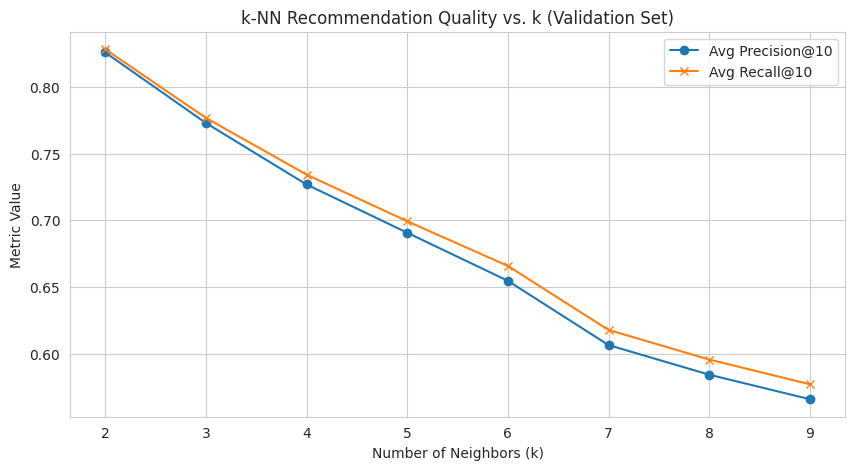


Selected best k = 2 based on validation results (max Precision@10).

--- Evaluating final model with k = 2 on Test Set ---
Test Set Results (k=2): Avg Precision@10 = 0.7835, Avg Recall@10 = 0.7891


In [ ]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # --- 1. Prepare Data for Splitting ---
    # Ensure feature_matrix_df and target_admissions are aligned
    # Reset index if they are not already simple 0..N-1 indices
    feature_matrix = feature_matrix_df.reset_index(drop=True)
    # Assuming df_processed holds the target lists and aligns with df_cleaned before feature matrix creation
    target_admissions_series = df_processed.reset_index(drop=True)['AdmitReceived_Universities']

    if feature_matrix.shape[0] != len(target_admissions_series):
        raise ValueError("Feature matrix and target admissions are not aligned after reset_index.")

    # --- 2. Create Train-Validation-Test Split ---
    # First split into Train+Validation (80%) and Test (20%)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        feature_matrix, target_admissions_series,
        test_size=0.20, # 20% for test set
        random_state=42, # For reproducibility
        # Stratify if target is categorical/binary; less direct here with list target
    )

    # Split Train+Validation into Train (e.g., 75% of 80% = 60%) and Validation (e.g., 25% of 80% = 20%)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=0.25, # 0.25 * 0.80 = 0.20 (for validation set)
        random_state=42 # For reproducibility
    )

    print("Data Split Shapes:")
    print(f"Train:      X_train {X_train.shape}, y_train {len(y_train)}")
    print(f"Validation: X_val {X_val.shape}, y_val {len(y_val)}")
    print(f"Test:       X_test {X_test.shape}, y_test {len(y_test)}")

    # Convert target lists (Pandas series) to simple lists for easier handling later
    y_train_list = y_train.tolist()
    y_val_list = y_val.tolist()
    y_test_list = y_test.tolist()


    # --- 3. Function to Calculate Precision/Recall @ N ---
    def calculate_precision_recall(recommendations, true_admissions, n_val):
        """Calculates Precision@N and Recall@N for recommendation lists."""
        if not true_admissions: # Handle cases where student had no admits recorded
            return (1.0, 1.0) if not recommendations else (0.0, 0.0) # Or return NaN? Treat as perfect if no recs needed? Let's say 0/0 if recs made.

        top_n_recs = recommendations[:n_val]
        relevant_recommendations = set(top_n_recs) & set(true_admissions)

        precision = len(relevant_recommendations) / n_val if n_val > 0 else 0.0
        recall = len(relevant_recommendations) / len(true_admissions) if len(true_admissions) > 0 else 0.0

        return precision, recall

    # --- 4. Tune k using Validation Set ---
    k_values = [2, 3, 4, 5, 6, 7, 8, 9] # Range of k to test
    N_eval = 10 # Evaluate Precision/Recall @ Top 10 recommendations

    results = []

    for k_val in k_values:
        print(f"\n--- Evaluating k = {k_val} ---")
        # Fit model ONLY on training data
        nn_model_eval = NearestNeighbors(n_neighbors=k_val + 1, metric='cosine', algorithm='auto')
        nn_model_eval.fit(X_train)

        total_precision = 0
        total_recall = 0
        num_val_students = X_val.shape[0]

        # Define the recommendation function (slightly adapted for evaluation)
        # (Assuming get_knn_recommendations function from previous step is available)
        # OR redefine it here for clarity:
        def get_knn_recs_eval(new_vector, k, model, train_admissions):
            if new_vector.ndim == 1: new_vector = new_vector.reshape(1, -1)
            distances, indices = model.kneighbors(new_vector)
            neighbor_indices = indices[0]
            if distances[0][0] < 1e-6: neighbor_indices = neighbor_indices[1:] # Exclude self
            else: neighbor_indices = neighbor_indices[:k]

            agg_admissions = []
            for index in neighbor_indices:
                if 0 <= index < len(train_admissions):
                    admissions = train_admissions[index]
                    if isinstance(admissions, list): agg_admissions.extend(admissions)
            if not agg_admissions: return []
            counts = Counter(agg_admissions)
            sorted_recs = sorted(counts.items(), key=lambda item: (-item[1], item[0]))
            return [uni for uni, count in sorted_recs]

        # Evaluate each student in validation set
        for i in range(num_val_students):
            val_vector = X_val.iloc[i].values
            true_admissions = y_val_list[i]

            # Get recommendations using the model fitted on TRAINING data and TRAINING targets
            recommendations = get_knn_recs_eval(val_vector, k_val, nn_model_eval, y_train_list)

            precision, recall = calculate_precision_recall(recommendations, true_admissions, N_eval)
            total_precision += precision
            total_recall += recall

        avg_precision = total_precision / num_val_students
        avg_recall = total_recall / num_val_students
        results.append({'k': k_val, 'Avg Precision@10': avg_precision, 'Avg Recall@10': avg_recall})
        print(f"k={k_val}: Avg Precision@10 = {avg_precision:.4f}, Avg Recall@10 = {avg_recall:.4f}")

    # --- 5. Analyze Results and Choose Best k ---
    # Analyze Results and Choose Best k
    results_df = pd.DataFrame(results)
    print("\n--- Validation Results ---")
    print(results_df)

    # Plot results (keep this part)
    plt.figure(figsize=(10, 5))
    plt.plot(results_df['k'], results_df['Avg Precision@10'], marker='o', label='Avg Precision@10')
    plt.plot(results_df['k'], results_df['Avg Recall@10'], marker='x', label='Avg Recall@10')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Metric Value')
    plt.title('k-NN Recommendation Quality vs. k (Validation Set)')
    plt.legend()
    plt.grid(True)
    plt.show()

    best_k = results_df.loc[results_df['Avg Precision@10'].idxmax()]['k'].astype(int)
    print(f"\nSelected best k = {best_k} based on validation results (max Precision@10).")


    # --- 6. Final Evaluation on Test Set (Optional but Recommended) ---
    print(f"\n--- Evaluating final model with k = {best_k} on Test Set ---")
    # Fit model on the COMBINED Train+Validation data
    nn_model_final = NearestNeighbors(n_neighbors=best_k + 1, metric='cosine', algorithm='auto')
    nn_model_final.fit(X_train_val)
    y_train_val_list = y_train_val.tolist()

    total_precision_test = 0
    total_recall_test = 0
    num_test_students = X_test.shape[0]

    for i in range(num_test_students):
        test_vector = X_test.iloc[i].values
        true_admissions_test = y_test_list[i]
        recommendations_test = get_knn_recs_eval(test_vector, best_k, nn_model_final, y_train_val_list)
        precision_test, recall_test = calculate_precision_recall(recommendations_test, true_admissions_test, N_eval)
        total_precision_test += precision_test
        total_recall_test += recall_test

    avg_precision_test = total_precision_test / num_test_students
    avg_recall_test = total_recall_test / num_test_students
    print(f"Test Set Results (k={best_k}): Avg Precision@10 = {avg_precision_test:.4f}, Avg Recall@10 = {avg_recall_test:.4f}")

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # --- 6. Final Evaluation on Test Set (Optional but Recommended) ---
    print(f"\n--- Evaluating final model with k = {best_k} on Test Set ---")
    # Fit model on the COMBINED Train+Validation data
    nn_model_final = NearestNeighbors(n_neighbors=best_k + 1, metric='cosine', algorithm='auto')
    nn_model_final.fit(X_train_val)
    y_train_val_list = y_train_val.tolist()

    total_precision_test = 0
    total_recall_test = 0
    num_test_students = X_test.shape[0]

    for i in range(num_test_students):
        test_vector = X_test.iloc[i].values
        true_admissions_test = y_test_list[i]
        recommendations_test = get_knn_recs_eval(test_vector, best_k, nn_model_final, y_train_val_list)
        precision_test, recall_test = calculate_precision_recall(recommendations_test, true_admissions_test, N_eval)
        total_precision_test += precision_test
        total_recall_test += recall_test

    avg_precision_test = total_precision_test / num_test_students
    avg_recall_test = total_recall_test / num_test_students
    print(f"Test Set Results (k={best_k}): Avg Precision@10 = {avg_precision_test:.4f}, Avg Recall@10 = {avg_recall_test:.4f}")


--- Evaluating final model with k = 2 on Test Set ---
Test Set Results (k=2): Avg Precision@10 = 0.7835, Avg Recall@10 = 0.7891


#TREE MODELS

In [ ]:
df = pd.read_excel("/content/Data_21-24 (1)-1.xlsx", index_col=0)

<class 'pandas.core.frame.DataFrame'>
Index: 3836 entries, Aniket Dandawate to JayaShankar Mangina
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Email                           3836 non-null   object        
 1   Gender                          3836 non-null   int64         
 2   Interested Countries            3699 non-null   object        
 3   Parent Phone Number             3764 non-null   object        
 4   Student Phone Number            3780 non-null   object        
 5   Passport Number                 3699 non-null   object        
 6   Requires Essay                  3836 non-null   bool          
 7   Requires Lor                    3836 non-null   bool          
 8   Requires Sop                    3836 non-null   bool          
 9   Term Name                       3836 non-null   object        
 10  UserId                          0 non-null     

In [ ]:
if 'Is Competitive Exam Given' in df.columns:
    print("Column 'Is Competitive Exam Given' exists in df.")
    print("Value Counts (including NaNs):")
    print(df['Is Competitive Exam Given'].value_counts(dropna=False))
    # Check data type as well
    print(f"Data type: {df['Is Competitive Exam Given'].dtype}")

    # Also, let's re-check the scores *before* they are potentially overwritten
    # Make sure the column name is correct for your raw data before conversion
    print("\nChecking original competitive scores in df_us (after potential to_numeric):")
    original_scores = pd.to_numeric(df['Total Score (Competitive Exam)'], errors='coerce')
    print(original_scores.value_counts(dropna=False))

else:
    print("ERROR: Column 'Is Competitive Exam Given' DOES NOT EXIST in df!")

Column 'Is Competitive Exam Given' exists in df.
Value Counts (including NaNs):
Is Competitive Exam Given
1.0    2331
0.0    1401
NaN     104
Name: count, dtype: int64
Data type: float64

Checking original competitive scores in df_us (after potential to_numeric):
Total Score (Competitive Exam)
NaN       1505
305.0       74
304.0       73
312.0       70
314.0       69
          ... 
740.0        1
480.0        1
1290.0       1
1050.0       1
840.0        1
Name: count, Length: 127, dtype: int64


In [ ]:
print("\nParsing College Details...")

def parse_college_details(details):
    if pd.isna(details):
        return pd.Series([np.nan] * 4) # Return NaNs if input is NaN

    # Regex to capture: Major, College, University, Year
    # Adjust pattern if format varies significantly
    # Using non-greedy matching (.*?) and being specific about keywords
    pattern = r"^(.*?),\s*College:\s*(.*?),\s*University:\s*(.*?),\s*Year:\s*(\d{4})$"
    match = re.search(pattern, str(details).strip())

    if match:
        ug_major = match.group(1).strip()
        ug_college = match.group(2).strip()
        ug_university = match.group(3).strip()
        ug_year = int(match.group(4)) # Convert year to integer
        return pd.Series([ug_major, ug_college, ug_university, ug_year])
    else:
        # Attempt simpler parsing if primary fails (e.g. if missing parts)
        # Fallback: return NaNs or try extracting at least year/major if possible
        # This part might need refinement based on actual variations in your data
        year_match = re.search(r"Year:\s*(\d{4})", str(details))
        ug_year = int(year_match.group(1)) if year_match else np.nan
        # Add more fallback logic if needed
        return pd.Series([np.nan] * 3 + [ug_year]) # Example fallback

# Apply the function to create new columns
parsed_cols = ['UG_Major', 'UG_College_Name', 'UG_University_Name', 'UG_Year_of_Graduation']
df[parsed_cols] = df['College Details'].apply(parse_college_details)



Parsing College Details...


In [ ]:
print("\nCalculating Overall GPA on 4.0 Scale...")

# Define the list of score columns
score_columns = [
    'First Year Score', 'Second Year Score', 'Third Year Score',
    'Fourth Year Score', 'Fifth Year Score', 'Sixth Year Score',
    'Seventh Year Score', 'Eighth Year Score'
]

# Convert score columns to numeric, coercing errors to NaN
for col in score_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

def calculate_gpa_4_scale(row):
    system = row['Grading Systen']
    scores = row[score_columns].tolist()
    valid_scores = []

    if pd.isna(system):
        return np.nan

    # Determine scale and outlier bounds
    max_scale = np.nan
    lower_bound = np.nan
    upper_bound = np.nan

    if system == 'CGPA10':
        max_scale = 10.0
        lower_bound = 1.0 # Adjust if lower scores are valid
        upper_bound = 10.0
    elif system == 'GPA7':
        max_scale = 7.0
        lower_bound = 1.0 # Adjust if lower scores are valid
        upper_bound = 7.0
    elif system == 'Default': # Percentage scale
        max_scale = 100.0
        lower_bound = 35.0 # Assuming scores below 35% are outliers/fails to ignore
        upper_bound = 100.0
    else: # Handle unexpected systems
        return np.nan

    # Filter scores
    for score in scores:
        if pd.notna(score) and lower_bound <= score <= upper_bound:
             valid_scores.append(score)

    # Calculate average and convert
    if not valid_scores: # Check if list is empty
        return np.nan
    else:
        average_score = sum(valid_scores) / len(valid_scores)
        return (average_score / max_scale) * 4.0

# Apply the function row-wise
df['Overall_GPA_4_Scale'] = df.apply(calculate_gpa_4_scale, axis=1)



Calculating Overall GPA on 4.0 Scale...


In [ ]:
if 'Is Competitive Exam Given' in df.columns:
    print("Column 'Is Competitive Exam Given' exists in df.")
    print("Value Counts (including NaNs):")
    print(df['Is Competitive Exam Given'].value_counts(dropna=False))
    # Check data type as well
    print(f"Data type: {df['Is Competitive Exam Given'].dtype}")

    # Also, let's re-check the scores *before* they are potentially overwritten
    # Make sure the column name is correct for your raw data before conversion
    print("\nChecking original competitive scores in df_us (after potential to_numeric):")
    original_scores = pd.to_numeric(df['Total Score (Competitive Exam)'], errors='coerce')
    print(original_scores.value_counts(dropna=False))

else:
    print("ERROR: Column 'Is Competitive Exam Given' DOES NOT EXIST in df!")

Column 'Is Competitive Exam Given' exists in df.
Value Counts (including NaNs):
Is Competitive Exam Given
1.0    2331
0.0    1401
NaN     104
Name: count, dtype: int64
Data type: float64

Checking original competitive scores in df_us (after potential to_numeric):
Total Score (Competitive Exam)
NaN       1505
305.0       74
304.0       73
312.0       70
314.0       69
          ... 
740.0        1
480.0        1
1290.0       1
1050.0       1
840.0        1
Name: count, Length: 127, dtype: int64


In [ ]:
print("\nHandling Test Scores")

# Define Max Scores
MAX_SCORES = {
    'GRE': 340,
    'GMAT': 800,  # Traditional GMAT Max
    'SAT': 1600,
    'ACT': 36
}

# --- Language Exam (No changes needed here from previous correction) ---
lang_score_col = 'Total Score (Language Exam)'
lang_given_col = 'Is Language Exam Given'
df[lang_score_col] = pd.to_numeric(df[lang_score_col], errors='coerce')
df[lang_given_col] = pd.to_numeric(df[lang_given_col], errors='coerce')
df.loc[(df[lang_given_col] == 0.0) | (df[lang_given_col].isna()), lang_score_col] = 0
df.loc[(df[lang_given_col] == 1.0) & (df[lang_score_col].isna()), lang_score_col] = -2

# --- Competitive Exam ---
comp_score_col = 'Total Score (Competitive Exam)'
comp_given_col = 'Is Competitive Exam Given'
comp_exam_type_col = 'Competitive Exam' # Column specifying GRE/GMAT/SAT/ACT

# Ensure score column is numeric
df[comp_score_col] = pd.to_numeric(df[comp_score_col], errors='coerce')
# Ensure 'Is Given' column is numeric/float
df[comp_given_col] = pd.to_numeric(df[comp_given_col], errors='coerce')

# Apply logic based on the 'Is Given' flag (1.0 = Yes, 0.0 = No, NaN = Treat as No)
df.loc[(df[comp_given_col] == 0.0) | (df[comp_given_col].isna()), comp_score_col] = 0
df.loc[(df[comp_given_col] == 1.0) & (df[comp_score_col].isna()), comp_score_col] = -2

# !!! NEW CAPPING LOGIC !!!
# Ensure the Exam Type column is string and handle potential NaNs
df[comp_exam_type_col] = df[comp_exam_type_col].astype(str).fillna('UNKNOWN')

print("Applying score capping...")
for exam_type, max_score in MAX_SCORES.items():
    # Condition for rows matching the exam type AND score exceeding max
    condition = (
        (df[comp_exam_type_col].str.upper() == exam_type) &
        (df[comp_score_col] > max_score)
    )
    # Apply capping
    count_capped = condition.sum()
    if count_capped > 0:
        print(f"Capping {count_capped} scores for {exam_type} at {max_score}")
        df.loc[condition, comp_score_col] = max_score

# --- Verification ---
print("Sample processed test scores (Corrected + Capped):")
print(df[[lang_given_col, lang_score_col, comp_given_col, comp_score_col, comp_exam_type_col]].head())
print("\nValue counts for Competitive Score after correction + capping:")
# Check if capping worked by looking at max values per exam type if needed
# print(df_us.groupby(comp_exam_type_col)[comp_score_col].max())
print(df[comp_score_col].value_counts(dropna=False))


Handling Test Scores
Applying score capping...
Sample processed test scores (Corrected + Capped):
                       Is Language Exam Given  Total Score (Language Exam)  \
Full Name                                                                    
Aniket Dandawate                          0.0                          0.0   
Abhiroop Ramachandran                     1.0                        107.0   
MANALI BHOSLE                             1.0                          6.0   
Shivani Zemse                             1.0                        107.0   
Gaurav Purohit                            1.0                        107.0   

                       Is Competitive Exam Given  \
Full Name                                          
Aniket Dandawate                             0.0   
Abhiroop Ramachandran                        1.0   
MANALI BHOSLE                                0.0   
Shivani Zemse                                1.0   
Gaurav Purohit                            

In [ ]:
# --- Attempt to create StudentID column ---
print("Attempting to reset index and rename...")
df = df.reset_index().rename(columns={'index': 'StudentID'}) # Use index as StudentID

print("\nColumns PRESENT in 'df' AFTER reset_index/rename:")
print(df.columns.tolist())
# -----------------------------------------

# --- Define Feature Columns (Adjust based on actual cleaned df) ---
print("\nDefining feature columns list...")
student_features_to_keep = [
    'Overall_GPA_4_Scale',
    'Total Score (Language Exam)', # Use cleaned/capped scores
    'Total Score (Competitive Exam)', # Use cleaned/capped scores
    'Language Exam',
    'Competitive Exam',
    'Future Desired Degree',
    'Desired Field of Study',
    'Desired Specialization'
]
required_cols_check = student_features_to_keep + ['Suggested Universities', 'StudentID']

# --- Check for required columns (This is where the error occurs) ---
print("\nChecking if required columns exist...")
missing_cols_check = [col for col in required_cols_check if col not in df.columns]

if missing_cols_check:
    print(f"DEBUG: Columns currently in df before raising error: {df.columns.tolist()}") # Add another check just before error
    raise ValueError(f"Missing required columns after initial cleaning: {missing_cols_check}")
else:
    print("All required columns found.")


# --- This part will only run if the check passes ---
df_for_restructure = df[required_cols_check].copy() # Keep only needed columns
print("Successfully created df_for_restructure.")

Attempting to reset index and rename...

Columns PRESENT in 'df' AFTER reset_index/rename:
['StudentID', 'Full Name', 'Email', 'Gender', 'Interested Countries', 'Parent Phone Number', 'Student Phone Number', 'Passport Number', 'Requires Essay', 'Requires Lor', 'Requires Sop', 'Term Name', 'UserId', 'Total Fees Charged', 'Fees Paid', 'Expected Payment Date', 'Date Of Birth', 'Account Created On', 'Account Created By', 'Branch', 'Other Remarks', 'Language Exam', 'Is Language Exam Given', 'Total Score (Language Exam)', 'Competitive Exam', 'Is Competitive Exam Given', 'Total Score (Competitive Exam)', 'Current Education', 'Future Desired Degree', 'Desired Course', 'Desired Field of Study', 'Desired Specialization', 'University Suggestion State', 'Suggested Universities', 'Finalized University', 'CWID Number', 'Partner Name', 'Grading Systen', 'College Details', 'First Year Score', 'Second Year Score', 'Third Year Score', 'Fourth Year Score', 'Fifth Year Score', 'Sixth Year Score', 'Seventh

In [ ]:
# --- Parsing Function ---
def parse_suggestions(text):
    suggestions = []
    if isinstance(text, str):
        lines = text.split('\n')
        for line in lines:
            parts = line.split('|')
            if len(parts) >= 2:
                uni_name = parts[0].strip()
                status = parts[1].strip().upper()
                if uni_name:
                    suggestions.append({'UniversityName': uni_name, 'Status': status})
    return suggestions


In [ ]:
# --- Generate Positive and Potential Negative Examples ---
print("Parsing suggestions and generating examples...")
all_examples_rows = []
positive_statuses = ['ADMITRECEIVED', 'FINALIZED', 'ACCEPTED'] # Define positive statuses

for index, student_row in df_for_restructure.iterrows():
    student_id = student_row['StudentID']
    suggestions_text = student_row['Suggested Universities']
    parsed_list = parse_suggestions(suggestions_text)
    if not parsed_list: continue

    student_features = student_row[student_features_to_keep].to_dict()

    for suggestion in parsed_list:
        example_row = student_features.copy()
        example_row['StudentID'] = student_id
        example_row['UniversityName'] = suggestion['UniversityName']
        status = suggestion['Status']
        example_row['Admitted'] = 1 if status in positive_statuses else 0
        all_examples_rows.append(example_row)

if not all_examples_rows:
     raise ValueError("No examples generated. Check 'Suggested Universities' data/parsing.")

all_examples_df = pd.DataFrame(all_examples_rows)
print(f"Generated {all_examples_df.shape[0]} raw examples.")


Parsing suggestions and generating examples...
Generated 19631 raw examples.


In [ ]:
# --- Ensure Consistency (Prioritize Positive) ---
print("Resolving conflicts...")
all_examples_df['Student_Uni_Key'] = all_examples_df['StudentID'].astype(str) + "||" + all_examples_df['UniversityName']
positive_df = all_examples_df[all_examples_df['Admitted'] == 1].drop_duplicates(subset=['Student_Uni_Key'])
negative_df = all_examples_df[all_examples_df['Admitted'] == 0]
negative_df = negative_df[~negative_df['Student_Uni_Key'].isin(set(positive_df['Student_Uni_Key']))].drop_duplicates(subset=['Student_Uni_Key'])
interaction_df = pd.concat([positive_df, negative_df], ignore_index=True)
interaction_df = interaction_df.drop(columns=['Student_Uni_Key'])
print(f"Interaction DataFrame shape after de-duplication: {interaction_df.shape}")
print("Final 'Admitted' distribution:")
print(interaction_df['Admitted'].value_counts(normalize=True))


Resolving conflicts...
Interaction DataFrame shape after de-duplication: (19120, 11)
Final 'Admitted' distribution:
Admitted
1    0.665586
0    0.334414
Name: proportion, dtype: float64


In [ ]:
# --- Final Feature Selection & NaN Handling ---
print("Selecting features and handling NaNs...")
# Define feature types (UniversityName is now categorical)
numerical_features = ['Overall_GPA_4_Scale', 'Total Score (Language Exam)', 'Total Score (Competitive Exam)']
categorical_features = [
    'Language Exam', 'Competitive Exam', 'Future Desired Degree',
    'Desired Field of Study', 'Desired Specialization', 'UniversityName'
]
features_to_use = numerical_features + categorical_features
# Ensure columns exist
available_features = [col for col in features_to_use if col in interaction_df.columns]
interaction_df_final = interaction_df[available_features + ['Admitted']].copy()

# Fill NaNs
for col in numerical_features:
    if col in interaction_df_final.columns:
        interaction_df_final[col] = interaction_df_final[col].fillna(interaction_df_final[col].median()) # Use median for scores
for col in categorical_features:
     if col in interaction_df_final.columns:
        interaction_df_final[col] = interaction_df_final[col].fillna('Unknown').astype(str)

X = interaction_df_final.drop('Admitted', axis=1)
y = interaction_df_final['Admitted']


Selecting features and handling NaNs...


In [ ]:
# --- Train-Test Split ---
print("Splitting data into Training (80%) and Testing (20%) sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20, # Held-out test set
    random_state=42,
    stratify=y
)
print(f"Training set shape: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Testing set shape: X_test {X_test.shape}, y_test {y_test.shape}")


# --- Data Restructuring Complete ---
print("\nData restructured. Ready for preprocessing pipeline and hyperparameter tuning.")


Splitting data into Training (80%) and Testing (20%) sets...
Training set shape: X_train (15296, 9), y_train (15296,)
Testing set shape: X_test (3824, 9), y_test (3824,)

Data restructured. Ready for preprocessing pipeline and hyperparameter tuning.


In [ ]:
# Phase 2: Defining Preprocessor & Tuning Models

# --- 1. Define Preprocessing Pipeline ---
# Re-identify numerical and categorical columns IN X_train (in case some were dropped)
current_numerical = [col for col in numerical_features if col in X_train.columns]
current_categorical = [col for col in categorical_features if col in X_train.columns]

# WARNING: OneHotEncoding 'UniversityName' might create VERY many features.
# Consider HashingVectorizer(n_features=...) or Target Encoding for UniversityName
# if dimensionality becomes problematic. For now, using OHE.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), current_numerical),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), current_categorical)
    ],
    remainder='drop' # Drop any columns not specified (like StudentID if it remained)
)


--- Phase 2: Defining Preprocessor & Tuning Models ---


In [ ]:
# --- 2. Define Parameter Grids ---
# Reduced grids for faster demonstration - expand ranges for thorough search
param_grid_rf = {
    'classifier__n_estimators': [200, 300, 450],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [5,7,15],
    'classifier__class_weight': ['balanced', None] # Handle imbalance
}

param_grid_xgb = {
    'classifier__n_estimators': [200, 300, 450],
    'classifier__max_depth': [7, 10, 15],
    'classifier__learning_rate': [0.1, 0.2, 0.3],
    'classifier__gamma': [0, 0.1]
    # Add 'scale_pos_weight' if severe imbalance needs addressing
}

In [ ]:
# --- 3. Set up Pipelines and GridSearchCV ---
param_grid_xgb = {
    'classifier__n_estimators': [1200],
    'classifier__max_depth': [75, 90, 105],
    'classifier__learning_rate': [0.4, 0.5, 0.6],
    'classifier__gamma': [0]
    # Add 'scale_pos_weight' if severe imbalance needs addressing
}
# XGBoost Pipeline
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))])

# GridSearchCV Instances
search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)


In [ ]:
# XGBoost Pipeline
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))])

search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
print("\nStarting GridSearchCV for XGBoost...")
search_xgb.fit(X_train, y_train)
print(f"Best XGB Params: {search_xgb.best_params_}")
print(f"Best XGB CV ROC-AUC: {search_xgb.best_score_:.4f}")
best_xgb_model = search_xgb.best_estimator_ # Save the best pipeline


Starting GridSearchCV for XGBoost...
Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:23:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGB Params: {'classifier__gamma': 0, 'classifier__learning_rate': 0.4, 'classifier__max_depth': 75, 'classifier__n_estimators': 1200}
Best XGB CV ROC-AUC: 0.8057


In [ ]:
# --- 4. Run Hyperparameter Tuning (on Training Data) ---
print("\nStarting GridSearchCV for Random Forest...")
search_rf.fit(X_train, y_train)
print(f"Best RF Params: {search_rf.best_params_}")
print(f"Best RF CV ROC-AUC: {search_rf.best_score_:.4f}")
best_rf_model = search_rf.best_estimator_ # Save the best pipeline

print("\nStarting GridSearchCV for XGBoost...")
search_xgb.fit(X_train, y_train)
print(f"Best XGB Params: {search_xgb.best_params_}")
print(f"Best XGB CV ROC-AUC: {search_xgb.best_score_:.4f}")
best_xgb_model = search_xgb.best_estimator_ # Save the best pipeline



Starting GridSearchCV for Random Forest...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best RF Params: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 30, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 450}
Best RF CV ROC-AUC: 0.7234

Starting GridSearchCV for XGBoost...
Fitting 3 folds for each of 54 candidates, totalling 162 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:29:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGB Params: {'classifier__gamma': 0, 'classifier__learning_rate': 0.3, 'classifier__max_depth': 15, 'classifier__n_estimators': 450}
Best XGB CV ROC-AUC: 0.7917


In [ ]:
def plot_cv_results(search_cv_object, param_x, param_hue, model_name):
    """
    Plots mean CV score against one hyperparameter, potentially hueing by another.
    Assumes search_cv_object is a fitted GridSearchCV instance.
    """
    cv_results = pd.DataFrame(search_cv_object.cv_results_)

    # Extract parameter names correctly (they are prefixed)
    param_x_col = f'param_classifier__{param_x}'
    param_hue_col = f'param_classifier__{param_hue}' if param_hue else None

    # Check if columns exist
    required_plot_cols = [param_x_col, 'mean_test_score']
    if param_hue_col:
        required_plot_cols.append(param_hue_col)
    if not all(col in cv_results.columns for col in required_plot_cols):
        print(f"Error: Not all required columns found in cv_results_ for plotting. Available: {cv_results.columns.tolist()}")
        print(f"Looking for: {required_plot_cols}")
        return

    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=cv_results,
        x=param_x_col,
        y='mean_test_score', # Mean score on validation folds during CV
        hue=param_hue_col, # Optional: Color lines by another parameter
        marker='o',
        errorbar=('ci', 95) # Show confidence interval if multiple runs per point
    )
    plt.title(f'{model_name}: Mean ROC-AUC vs. {param_x}' + (f' (Grouped by {param_hue})' if param_hue else ''))
    plt.xlabel(param_x)
    plt.ylabel('Mean ROC-AUC (Cross-Validation)')
    plt.grid(True)
    if param_hue_col:
        plt.legend(title=param_hue, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0, 0.85, 1])
    else:
        plt.tight_layout()
    plt.show()



--- Visualizing Random Forest Tuning Results ---


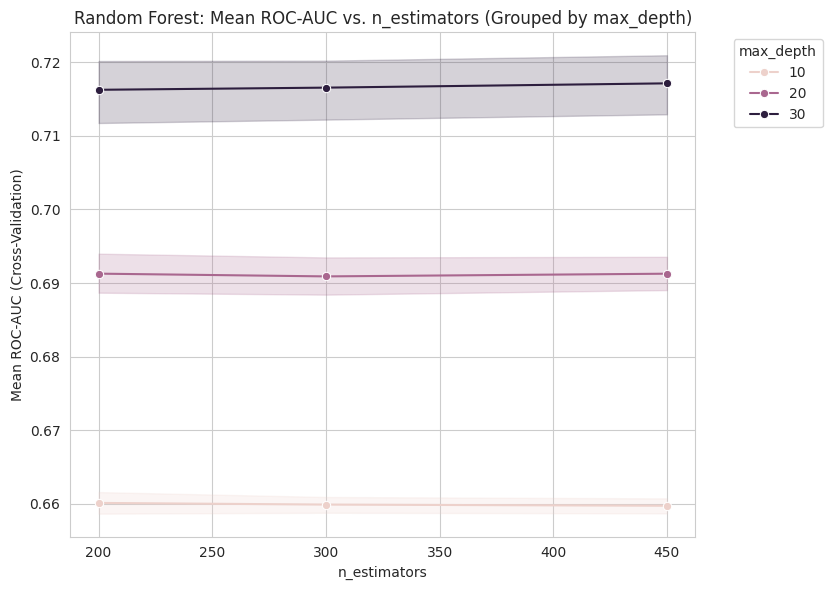

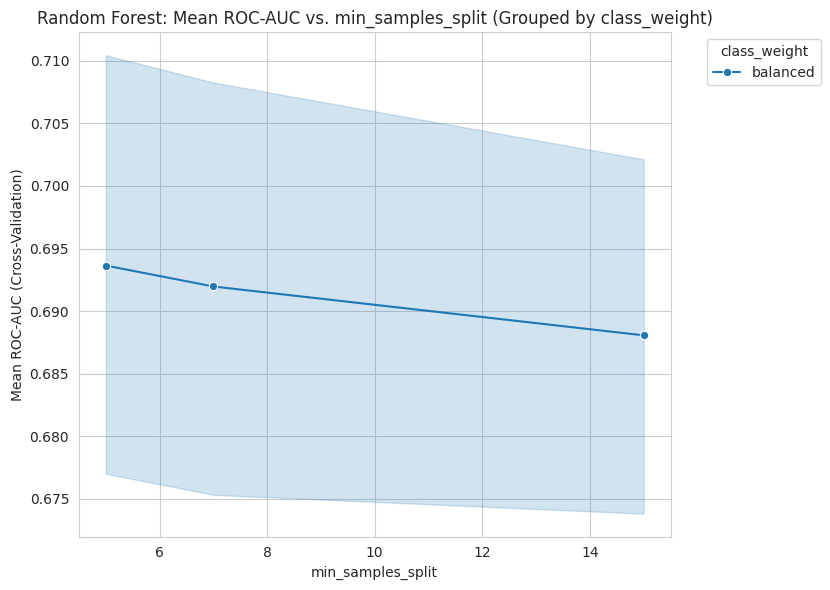

In [ ]:
# --- Plot for Random Forest ---
if 'search_rf' in locals() and hasattr(search_rf, 'best_estimator_'):
    print("\n--- Visualizing Random Forest Tuning Results ---")
    # Example: Plot ROC-AUC vs. n_estimators, grouped by max_depth
    plot_cv_results(search_rf, param_x='n_estimators', param_hue='max_depth', model_name='Random Forest')
    # Example: Plot ROC-AUC vs. min_samples_split, grouped by class_weight
    plot_cv_results(search_rf, param_x='min_samples_split', param_hue='class_weight', model_name='Random Forest')
else:
    print("Cannot plot RF results: 'search_rf' not found or not fitted.")


--- Visualizing XGBoost Tuning Results ---


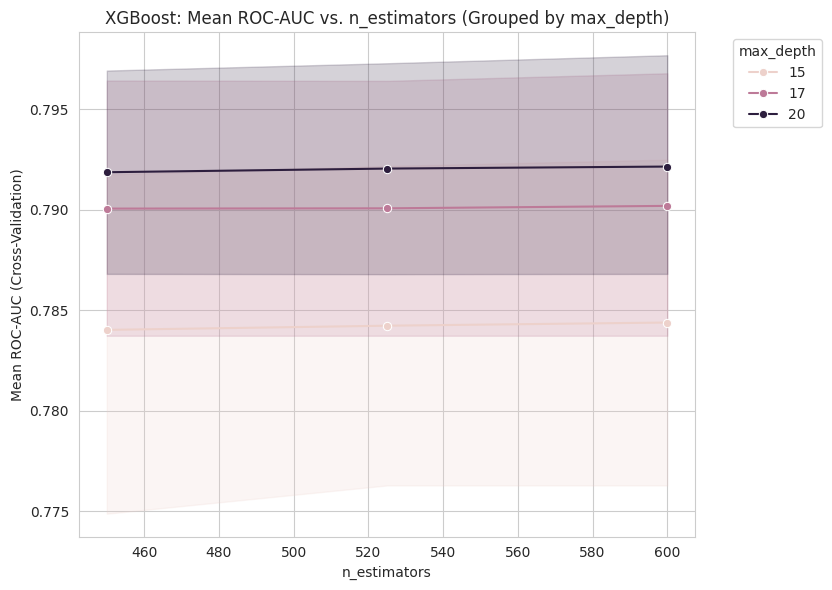

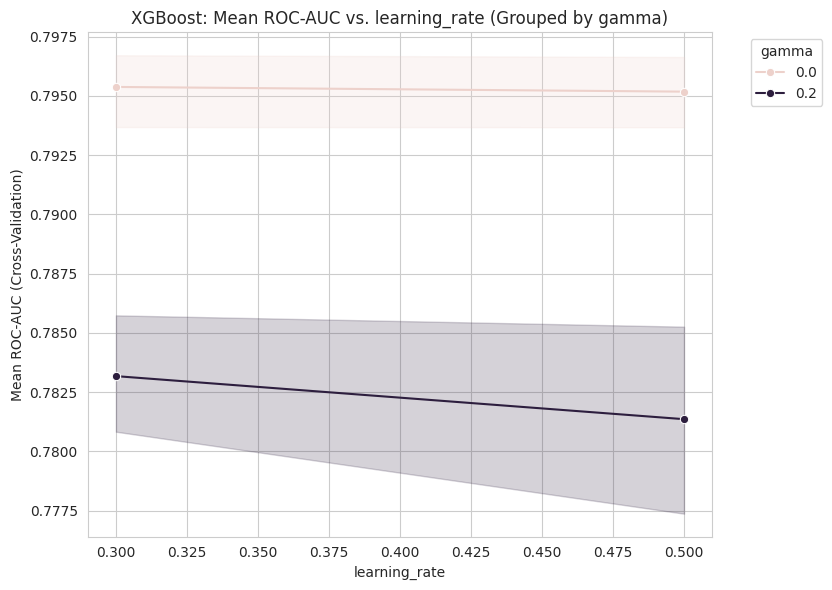

In [ ]:
# --- Plot for XGBoost ---
if 'search_xgb' in locals() and hasattr(search_xgb, 'best_estimator_'):
    print("\n--- Visualizing XGBoost Tuning Results ---")
    # Example: Plot ROC-AUC vs. n_estimators, grouped by max_depth
    plot_cv_results(search_xgb, param_x='n_estimators', param_hue='max_depth', model_name='XGBoost')
    # Example: Plot ROC-AUC vs. learning_rate, grouped by gamma
    plot_cv_results(search_xgb, param_x='learning_rate', param_hue='gamma', model_name='XGBoost')
else:
    print("Cannot plot XGBoost results: 'search_xgb' not found or not fitted.")

In [ ]:
# --- 5. Evaluate Best Models on Test Set ---
print("\n--- Evaluating Best Models on Test Set ---")

# Random Forest Evaluation
print("\n--- Random Forest (Test Set) ---")
y_pred_rf_test = best_rf_model.predict(X_test)
y_prob_rf_test = best_rf_model.predict_proba(X_test)[:, 1]
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_prob_rf_test):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_test))

# XGBoost Evaluation
print("\n--- XGBoost (Test Set) ---")
y_pred_xgb_test = best_xgb_model.predict(X_test)
y_prob_xgb_test = best_xgb_model.predict_proba(X_test)[:, 1]
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_prob_xgb_test):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb_test))

# --- Tuning and Evaluation Complete ---
print("\nHyperparameter tuning and test set evaluation complete.")


--- Evaluating Best Models on Test Set ---

--- Random Forest (Test Set) ---
Test ROC-AUC: 0.7205
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.56      0.54      1279
           1       0.77      0.74      0.75      2545

    accuracy                           0.68      3824
   macro avg       0.64      0.65      0.65      3824
weighted avg       0.69      0.68      0.68      3824

Confusion Matrix:
[[ 720  559]
 [ 673 1872]]

--- XGBoost (Test Set) ---
Test ROC-AUC: 0.8137
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      1279
           1       0.81      0.82      0.81      2545

    accuracy                           0.75      3824
   macro avg       0.72      0.71      0.72      3824
weighted avg       0.75      0.75      0.75      3824

Confusion Matrix:
[[ 782  497]
 [ 462 2083]]

Hyperparameter tuning and test set evaluation complete.


In [ ]:
import pandas as pd
import numpy as np
# Assuming 'best_xgb_model' is the fitted Pipeline object from GridSearchCV
# Assuming 'X_train' is the training feature DataFrame (before preprocessing in pipeline)
# 'interaction_df_final' or similar holds the original data used for X/y split

print("\n--- Defining Recommendation Function using XGBoost Model ---")

def recommend_universities_xgb(student_profile_dict, model_pipeline, candidate_universities, original_feature_columns, top_n=10):
    """
    Generates university recommendations for a student using a trained XGBoost pipeline.

    Args:
        student_profile_dict (dict): Dictionary containing the new student's features.
                                     Keys must match original feature columns before preprocessing.
        model_pipeline (Pipeline): The fitted Scikit-learn pipeline (preprocessor + XGBoost).
        candidate_universities (list): A list of university names to score.
        original_feature_columns (list): The list of feature column names expected by the
                                         pipeline's preprocessor (e.g., X_train.columns).
        top_n (int): The number of top recommendations to return.

    Returns:
        pandas.DataFrame: DataFrame with 'UniversityName' and 'AdmissionProbability',
                          sorted by probability, limited to top_n.
                          Returns empty DataFrame on error or no candidates.
    """
    if not candidate_universities:
        print("Warning: No candidate universities provided.")
        return pd.DataFrame({'UniversityName': [], 'AdmissionProbability': []})

    print(f"Generating predictions for {len(candidate_universities)} candidate universities...")

    # 1. Create input DataFrame for prediction
    # Repeat student profile for each candidate university
    student_df_list = []
    for university in candidate_universities:
        profile = student_profile_dict.copy()
        profile['UniversityName'] = university # Add the specific university name
        student_df_list.append(profile)

    input_df = pd.DataFrame(student_df_list)

    # Ensure columns match the order expected by the fitted preprocessor
    # Add missing columns as NaN if student_profile_dict was partial (might cause issues if not handled in preprocessor)
    try:
        input_df = input_df[original_feature_columns]
    except KeyError as e:
         print(f"Error: Input student profile is missing expected columns: {e}. Cannot predict.")
         print(f"Expected columns: {original_feature_columns}")
         print(f"Provided keys: {student_profile_dict.keys()}")
         return pd.DataFrame({'UniversityName': [], 'AdmissionProbability': []})


    # 2. Predict Probabilities using the full pipeline
    # The pipeline handles preprocessing internally before prediction
    try:
        print("Predicting probabilities...")
        probabilities = model_pipeline.predict_proba(input_df)
        # Probabilities array has shape (n_samples, n_classes), we want class 1 (Admitted)
        admission_probabilities = probabilities[:, 1]
        print("Prediction complete.")
    except Exception as e:
        print(f"Error during prediction: {e}")
        # Potentially print input_df.info() here for debugging
        return pd.DataFrame({'UniversityName': [], 'AdmissionProbability': []})


    # 3. Rank Universities
    results_df = pd.DataFrame({
        'UniversityName': candidate_universities,
        'AdmissionProbability': admission_probabilities
    })

    results_df = results_df.sort_values(by='AdmissionProbability', ascending=False)

    # 4. Return Top N
    return results_df.head(top_n)


# --- Example Usage ---

# ** PRE-REQUISITES **
# Ensure these exist from previous steps:
# - best_xgb_model: The fitted pipeline from GridSearchCV (search_xgb.best_estimator_)
# - X_train: The DataFrame used to train the model (needed for column names/order and candidate unis)

if 'best_xgb_model' in locals() and 'X_train' in locals():
    print("\n--- Generating Example Recommendations ---")

    # 1. Define a New Student Profile (Use exact column names from X_train)
    #    Use values *before* scaling/encoding. Fill all relevant features.
    new_student = {
        'Overall_GPA_4_Scale': 3.7, # Example GPA
        'Total Score (Language Exam)': 105.0, # Example TOEFL score
        'Language Exam': 'TOEFL',
        'Total Score (Competitive Exam)': 325.0, # Example GRE score
        'Competitive Exam': 'GRE',
        'Future Desired Degree': 'Masters',
        'Desired Field of Study': 'Computer Science', # Match categories used in training
        'Desired Specialization': 'Software Engineering' # Match categories used in training
        # Add any other features your model expects, e.g. UniversityName will be added in the function
    }
    print(f"New student profile: {new_student}")


    # 2. Get Candidate Universities (e.g., all unique universities seen in training)
    #    Using X_train['UniversityName'] avoids data leakage from test set
    try:
        candidate_universities = X_train['UniversityName'].unique().tolist()
        print(f"Number of candidate universities from training data: {len(candidate_universities)}")
    except KeyError:
         print("Error: 'UniversityName' column not found in X_train. Cannot get candidates.")
         candidate_universities = []


    # 3. Get Original Feature Columns Order (from X_train used to fit preprocessor)
    original_feature_columns = X_train.columns.tolist()


    # 4. Call the Recommendation Function
    if candidate_universities:
        recommendations_df = recommend_universities_xgb(
            student_profile_dict=new_student,
            model_pipeline=best_xgb_model,
            candidate_universities=candidate_universities,
            original_feature_columns=original_feature_columns,
            top_n=10 # Request top 10 recommendations
        )

        print("\n--- Top Recommended Universities ---")
        print(recommendations_df)
    else:
        print("\nCannot generate recommendations as no candidate universities were found.")

else:
    print("\nCould not run example: 'best_xgb_model' or 'X_train' not found in environment.")


--- Defining Recommendation Function using XGBoost Model ---

--- Generating Example Recommendations ---
New student profile: {'Overall_GPA_4_Scale': 3.7, 'Total Score (Language Exam)': 105.0, 'Language Exam': 'TOEFL', 'Total Score (Competitive Exam)': 325.0, 'Competitive Exam': 'GRE', 'Future Desired Degree': 'Masters', 'Desired Field of Study': 'Computer Science', 'Desired Specialization': 'Software Engineering'}
Number of candidate universities from training data: 562
Generating predictions for 562 candidate universities...
Predicting probabilities...
Prediction complete.

--- Top Recommended Universities ---
                                        UniversityName  AdmissionProbability
18                            Arizona State University              0.998780
2                                    DROPPED/CANCELLED              0.976719
208  Indiana University of Purdue University – indi...              0.972433
99                    Illinois Institute of Technology              0.9

In [ ]:
university_admit_counts_df['NumberOfAdmits'].sum()

np.int64(1026)